# Requiremnets install

In [1]:
%pip install -r requirements.txt
from IPython.display import clear_output
clear_output()

# 0단계: 필요한 라이브러리 불러오기

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import logging

Importing plotly failed. Interactive plots will not work.


In [3]:
# Prophet의 불필요한 로그 메시지를 줄여서 출력을 깔끔하게 만듭니다.
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Matplotlib에서 한글 폰트가 깨지지 않도록 설정합니다. (환경에 맞는 폰트 지정)
# 만약 폰트가 없다면, 다른 폰트(예: 'Malgun Gothic')로 변경하거나 설치가 필요할 수 있습니다.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

print("0단계: 라이브러리 로드 완료")

0단계: 라이브러리 로드 완료


# 1단계: 데이터 불러오기 및 기본 전처리

## 1-1. 여러 CSV 파일 통합

In [4]:
folder_path = './farm_data'  # CSV 파일이 있는 폴더 경로
print(f"'{folder_path}' 폴더에서 CSV 파일을 읽습니다...")

# 폴더가 존재하는지 확인
if not os.path.isdir(folder_path):
    print(f"오류: '{folder_path}' 폴더를 찾을 수 없습니다. 폴더를 생성하고 CSV 파일을 넣어주세요.")
    exit()

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

if not csv_files:
    print(f"오류: '{folder_path}' 폴더에 CSV 파일이 없습니다.")
    exit()

dataframes = []
for f in csv_files:
    file_path = os.path.join(folder_path, f)
    try:
        # CSV 파일을 읽어올 때, 8번째와 16번째 열을 float로 지정
        df_temp = pd.read_csv(file_path, dtype={8: float, 16: float})
        dataframes.append(df_temp)
    except Exception as e:
        print(f"오류 발생 {file_path}: {e}")
        continue

# 모든 데이터프레임을 하나로 합칩니다.
raw_df = pd.concat(dataframes, ignore_index=True)
clear_output()
print("-> 모든 CSV 파일 통합 완료")

-> 모든 CSV 파일 통합 완료


## 1-2. 상세 전처리

In [5]:
print("-> 상세 전처리를 시작합니다...")

# df에서 지역명, 양식장 이름, 시설 이름, 시설 ID를 추출하여 dictionary 생성
facility_id_dict = {}
for index, row in raw_df.iterrows():
    # .get(key, default_value)를 사용하여 키가 없을 때 오류 방지
    region = row.get('지역명', '')
    farm_name = row.get('양식장 이름', '')
    facility_name = row.get('시설 이름', '')
    facility_id = row.get('시설 ID')
    
    if pd.isna(facility_id): continue # 시설 ID가 없는 행은 건너뜀
    
    facility_names = f"{region} {farm_name} {str(facility_name).replace(' ', '')}"
    
    if facility_id in facility_id_dict:
        if facility_id_dict[facility_id] != facility_names:
            print(f"시설 ID {facility_id}의 이름이 다릅니다: {facility_id_dict[facility_id]} vs {facility_names}")
    else:
        facility_id_dict[facility_id] = facility_names

# df에서 일자와 시간을 합쳐서 datetime 형식으로 변환 후 일시라는 항목으로 저장
raw_df['일시'] = pd.to_datetime(raw_df['일자'].astype(str) + ' ' + raw_df['시간'].astype(str), format='%Y-%m-%d %H:%M:%S', errors='coerce')

# 미사용 column 제거
columns_to_drop = [
    '일자','시간','지역명','양식장 이름','시설 이름','양식장 ID','지역코드',
    '유입수 탁도(fnu)', '유량1(m3/h)','유량2(m3/h)','유량3(m3/h)',
    'ORP(mV)', '전압', '전력', 'RPM', '주파수','PH(pH)', '유입수 염도(PPT)', 'DO(mg/L)'
]
df = raw_df.drop(columns=columns_to_drop, errors='ignore')

-> 상세 전처리를 시작합니다...


## 1-3. 변화량 기반 이상치 필터링

In [6]:
df.sort_values(by=['시설 ID', '일시'], inplace=True)

# 각 시설 ID 그룹별로 바로 이전 데이터와의 수온 차이를 계산합니다. .abs()로 변화량의 절대값을 구합니다.
df['temp_diff'] = df.groupby('시설 ID')['수온(℃)'].diff().abs()

# 변화량의 임계값을 설정합니다. (예: 이전 측정값과 5도 이상 차이나면 이상치로 간주)
change_threshold = 5.0
change_outlier_condition = df['temp_diff'] > change_threshold
change_outlier_count = change_outlier_condition.sum()
print(f"-> 급격한 온도 변화(>{change_threshold}℃)가 감지된 데이터 {change_outlier_count}개를 '없는 데이터'로 처리합니다.")

# 해당 데이터를 없는 데이터(NaN)로 변경합니다.
df.loc[change_outlier_condition, '수온(℃)'] = np.nan
# 임시로 사용한 'temp_diff' 컬럼은 삭제합니다.
df.drop(columns=['temp_diff'], inplace=True)


-> 급격한 온도 변화(>5.0℃)가 감지된 데이터 420개를 '없는 데이터'로 처리합니다.


## 1-4. 유효 수온 범위 필터링

In [7]:
# 유효한 수온의 범위를 정의합니다.
lower_bound = 5.0
upper_bound = 30.0

# 유효 범위를 벗어나는 데이터의 개수를 셉니다.
outlier_condition = (df['수온(℃)'] < lower_bound) | (df['수온(℃)'] > upper_bound)
outlier_count = outlier_condition.sum()
print(f"-> 유효범위({lower_bound}℃ ~ {upper_bound}℃)를 벗어난 데이터 {outlier_count}개를 '없는 데이터'로 처리합니다.")

# 해당 데이터를 없는 데이터(NaN)로 변경합니다.
df.loc[outlier_condition, '수온(℃)'] = np.nan

-> 유효범위(5.0℃ ~ 30.0℃)를 벗어난 데이터 7663개를 '없는 데이터'로 처리합니다.


## 1-5. Prophet을 위한 최종 데이터 준비

In [8]:
# 날짜 변환에 실패했거나(NaT), 수온 데이터가 없는 행은 분석에서 제외합니다.
df.dropna(subset=['일시', '수온(℃)'], inplace=True)

# '일시' 컬럼을 데이터프레임의 인덱스로 설정하고 변수 이름을 temper_df로 변경합니다.
temper_df = df.set_index('일시')

print("1단계: 데이터 로드 및 전처리 완료")

1단계: 데이터 로드 및 전처리 완료


# 2단계: 예측을 위한 기본 설정

In [9]:
main_figure_folder = 'figure'
os.makedirs(main_figure_folder, exist_ok=True)
print(f"'{main_figure_folder}' 폴더에 모든 그래프를 저장합니다.")


split_date = '2025-04-01'
facility_id_list = temper_df['시설 ID'].unique()
print(f"2단계: 기본 설정 완료 (총 {len(facility_id_list)}개 시설)")

'figure' 폴더에 모든 그래프를 저장합니다.
2단계: 기본 설정 완료 (총 19개 시설)


# 3단계: 시설별 반복 예측 및 분석

===== 61AF1-IW1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 719개
테스트 데이터 개수: 0개
-> [경고] 테스트 데이터가 없어 예측 성능 평가를 할 수 없으므로 건너뜁니다.

===== 61AF1-RT1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 719개
테스트 데이터 개수: 0개
-> [경고] 테스트 데이터가 없어 예측 성능 평가를 할 수 없으므로 건너뜁니다.

===== 61AF1-RT2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 719개
테스트 데이터 개수: 0개
-> [경고] 테스트 데이터가 없어 예측 성능 평가를 할 수 없으므로 건너뜁니다.

===== 61AF3-IW1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 30개


17:19:44 - cmdstanpy - INFO - Chain [1] start processing
17:19:44 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 1.24
-> 예측 구간 내 실제값 포함 비율 (Coverage): 100.00%


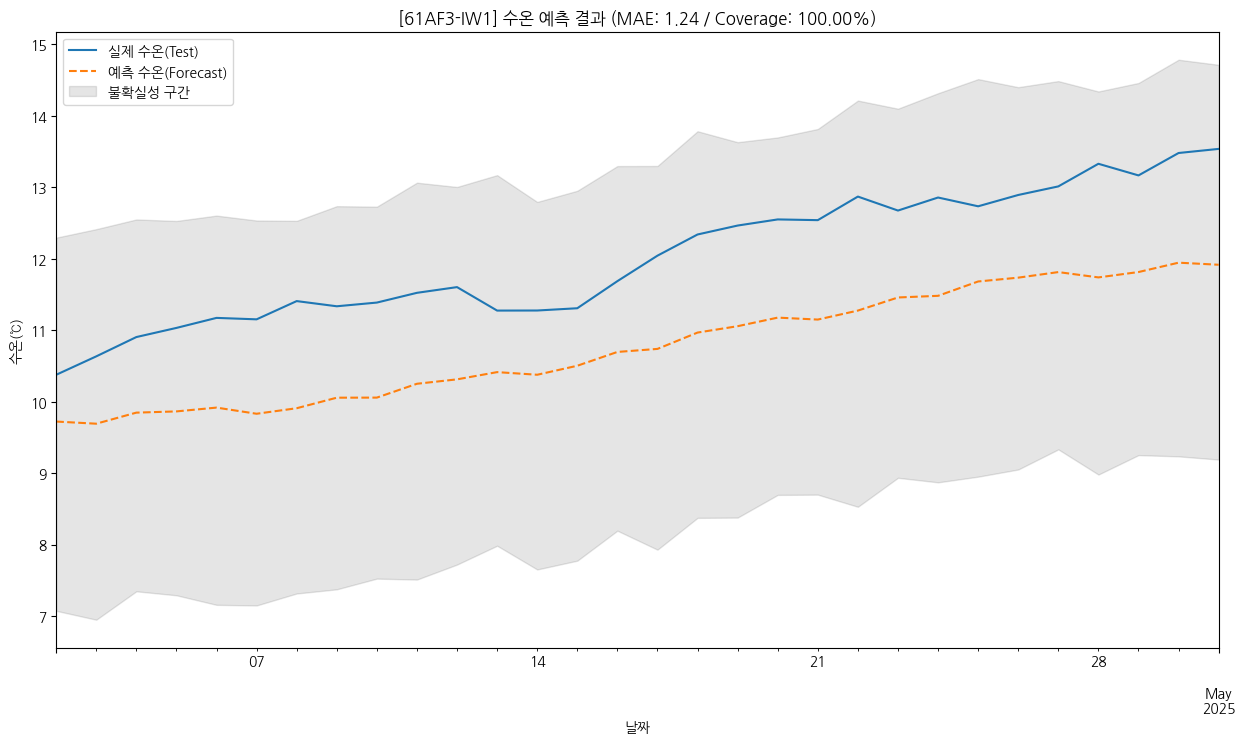

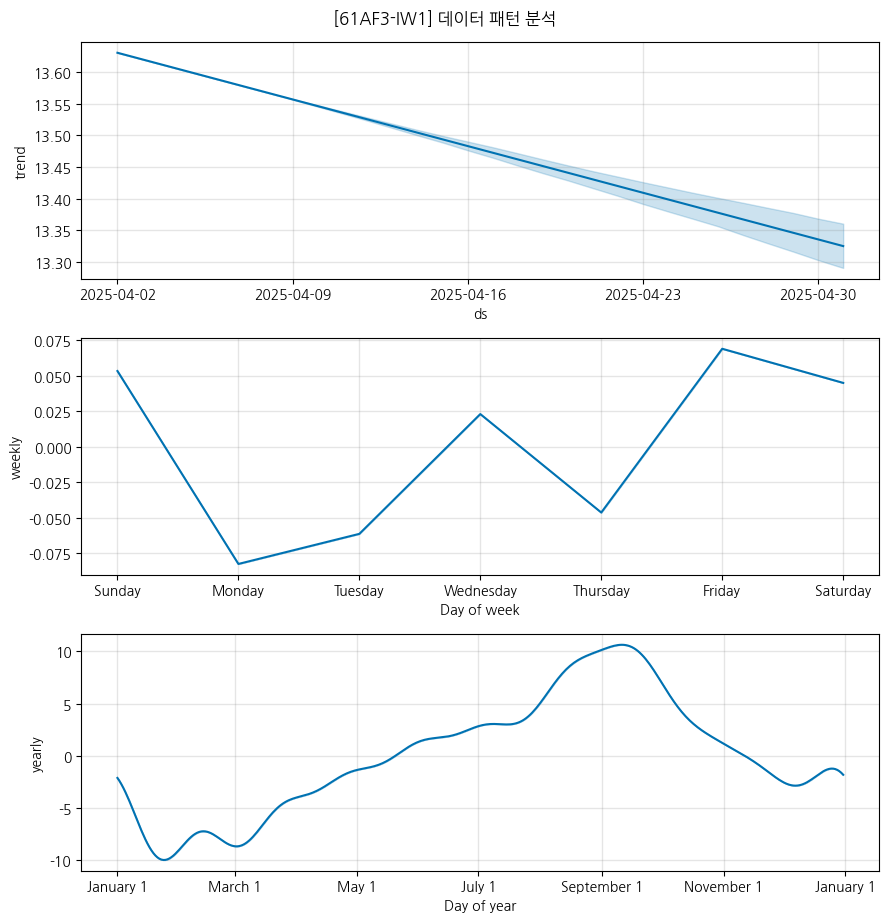

17:19:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------
===== 61AF3-RT1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 30개


17:19:45 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 3.02
-> 예측 구간 내 실제값 포함 비율 (Coverage): 0.00%


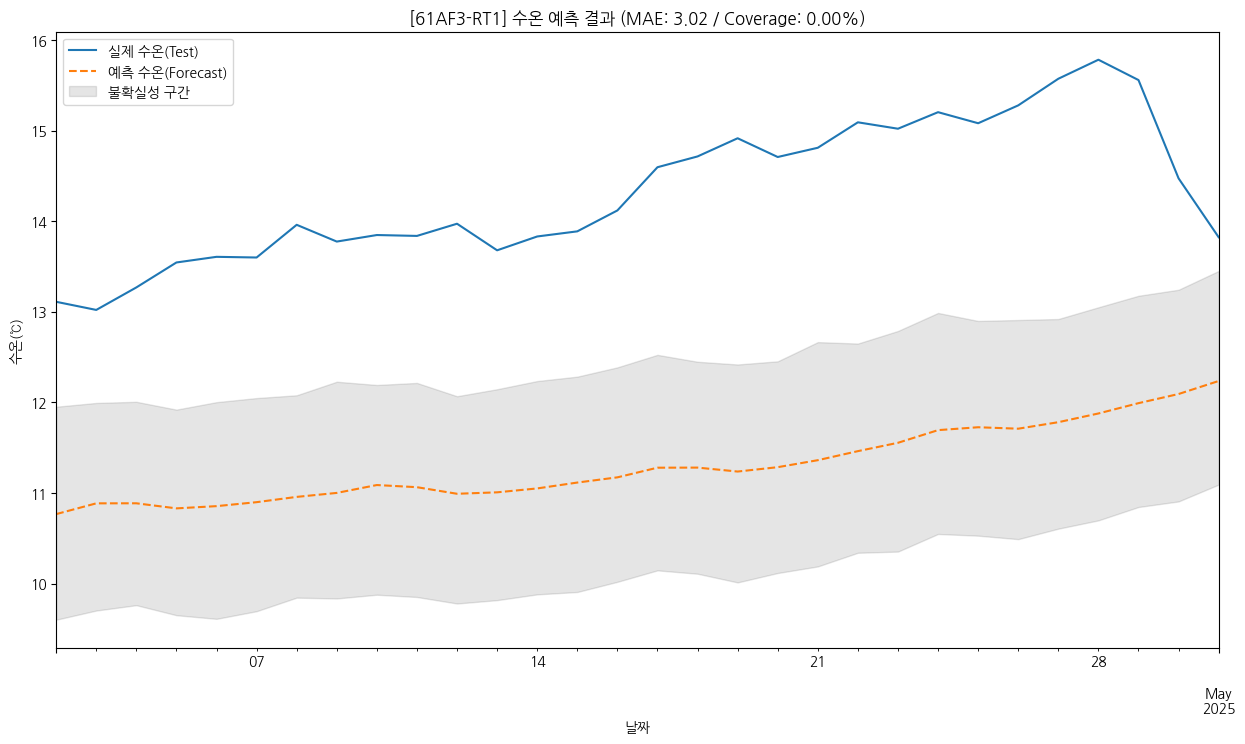

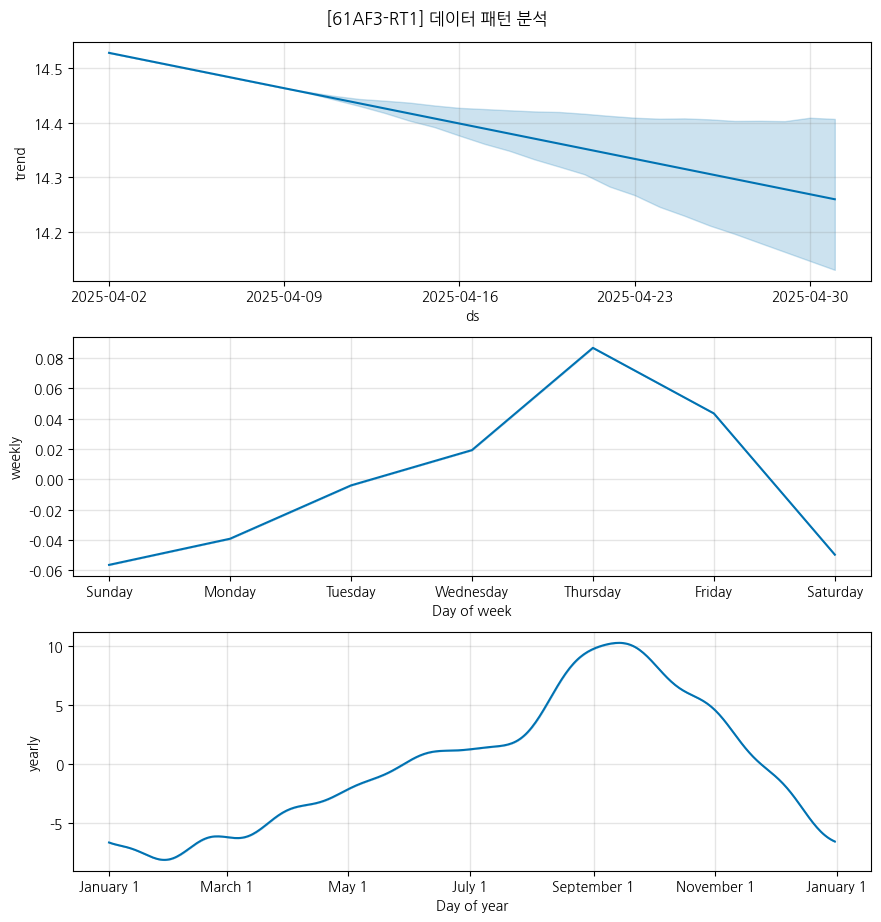

17:19:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------
===== 61AF3-RT2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 30개


17:19:46 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 2.24
-> 예측 구간 내 실제값 포함 비율 (Coverage): 3.33%


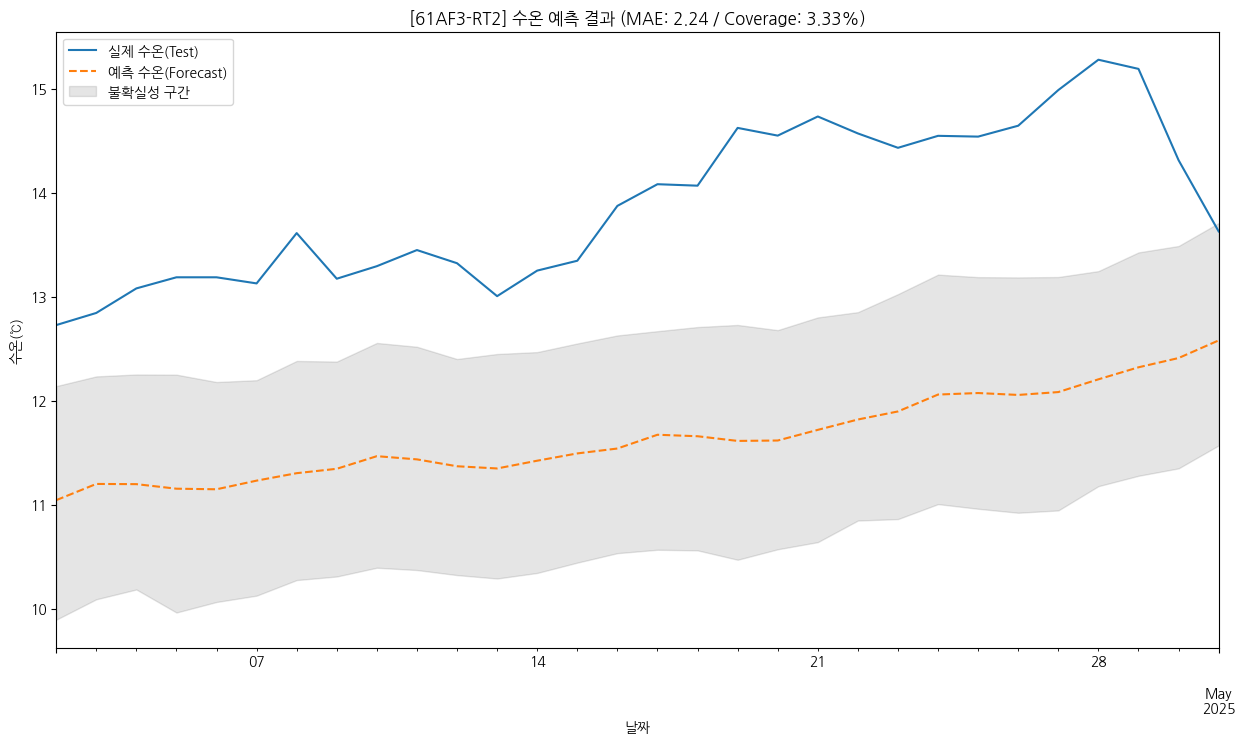

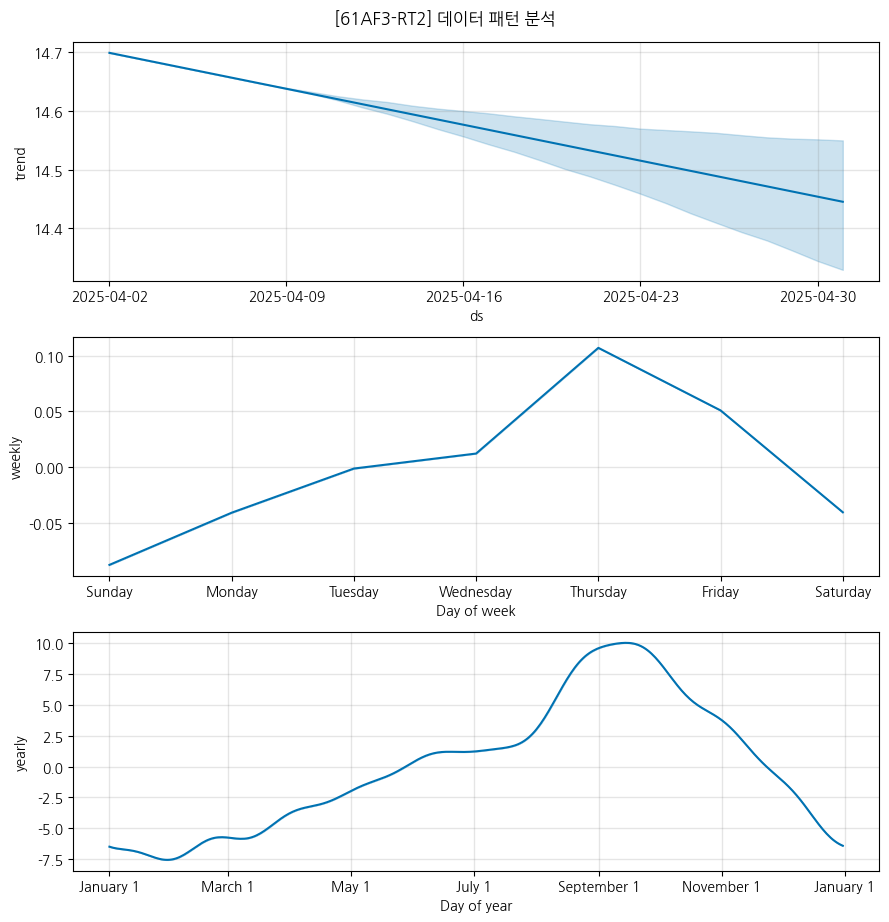

17:19:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------
===== 64AF1-IW1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개


17:19:47 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 0.31
-> 예측 구간 내 실제값 포함 비율 (Coverage): 95.92%


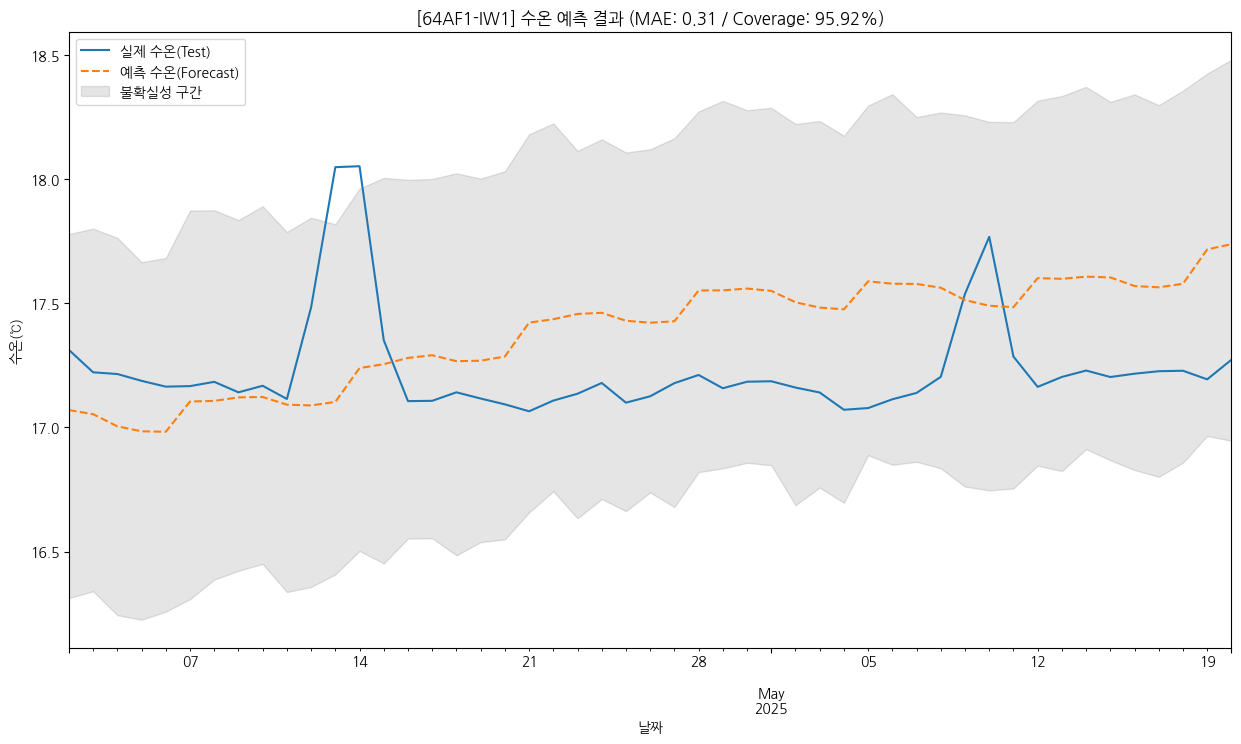

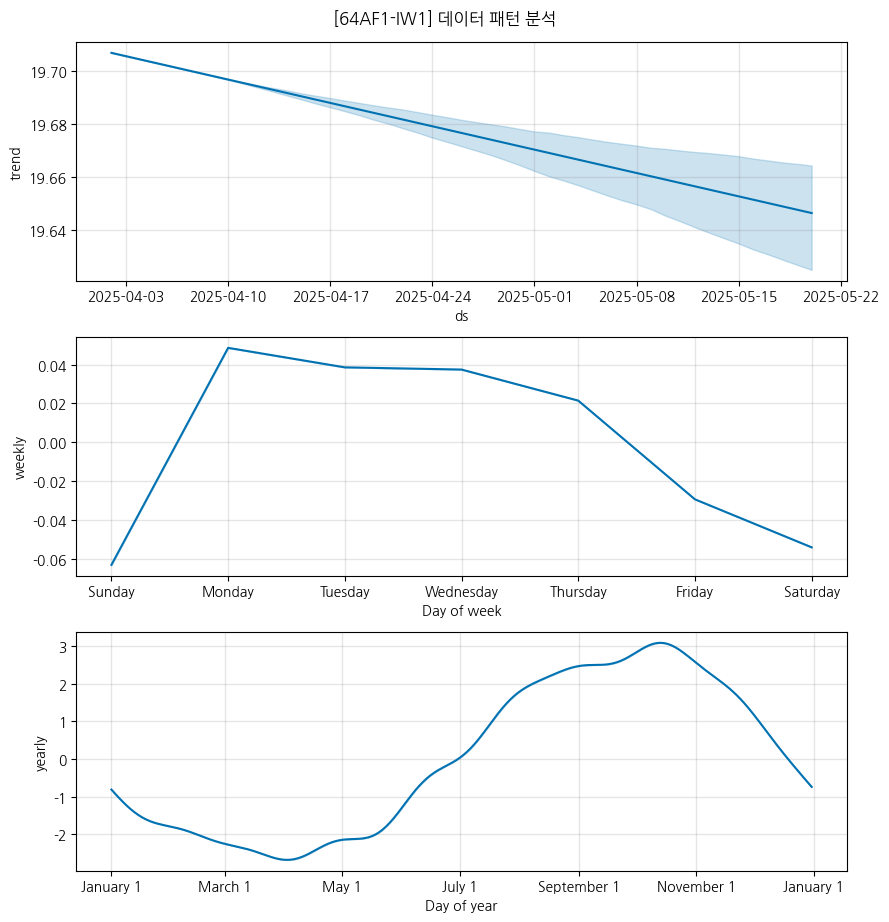

17:19:47 - cmdstanpy - INFO - Chain [1] start processing
17:19:47 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF1-RT1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.26
-> 예측 구간 내 실제값 포함 비율 (Coverage): 100.00%


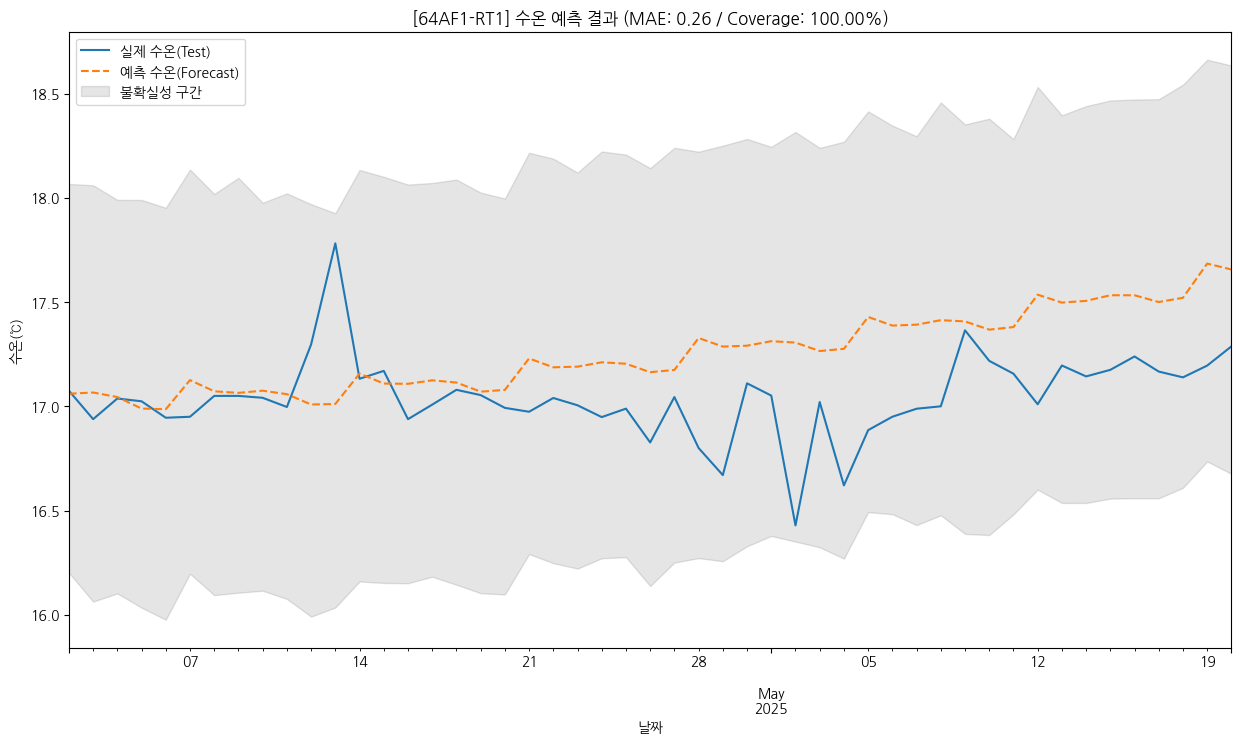

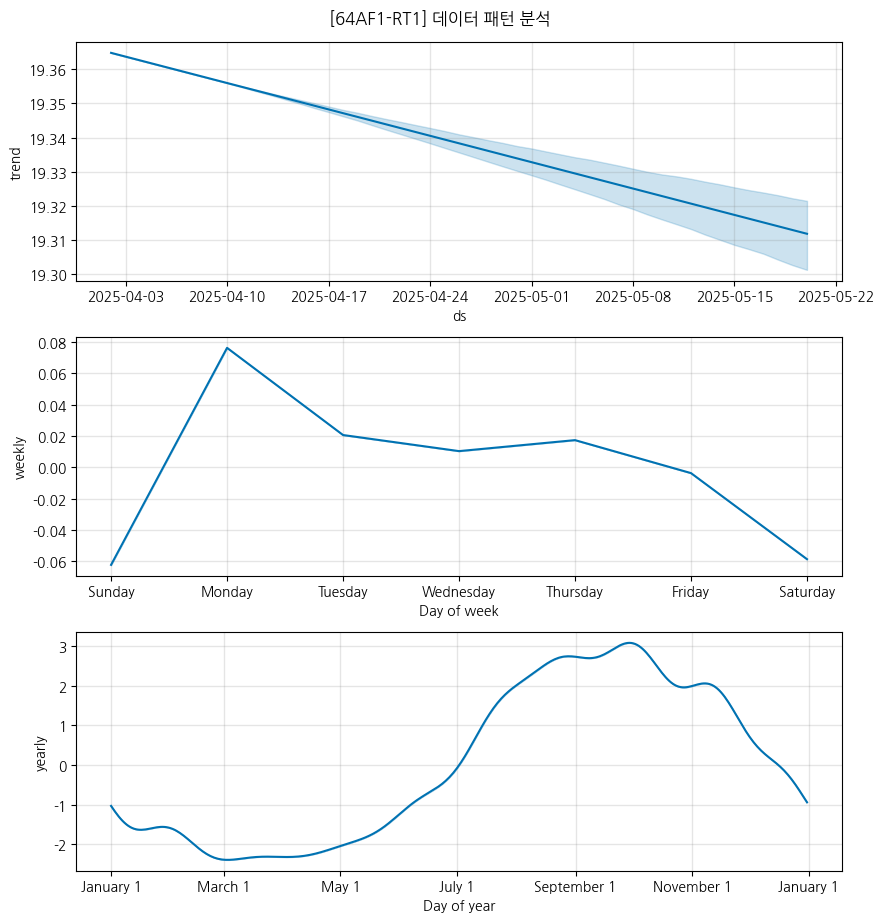

17:19:48 - cmdstanpy - INFO - Chain [1] start processing
17:19:48 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF1-RT2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.54
-> 예측 구간 내 실제값 포함 비율 (Coverage): 95.92%


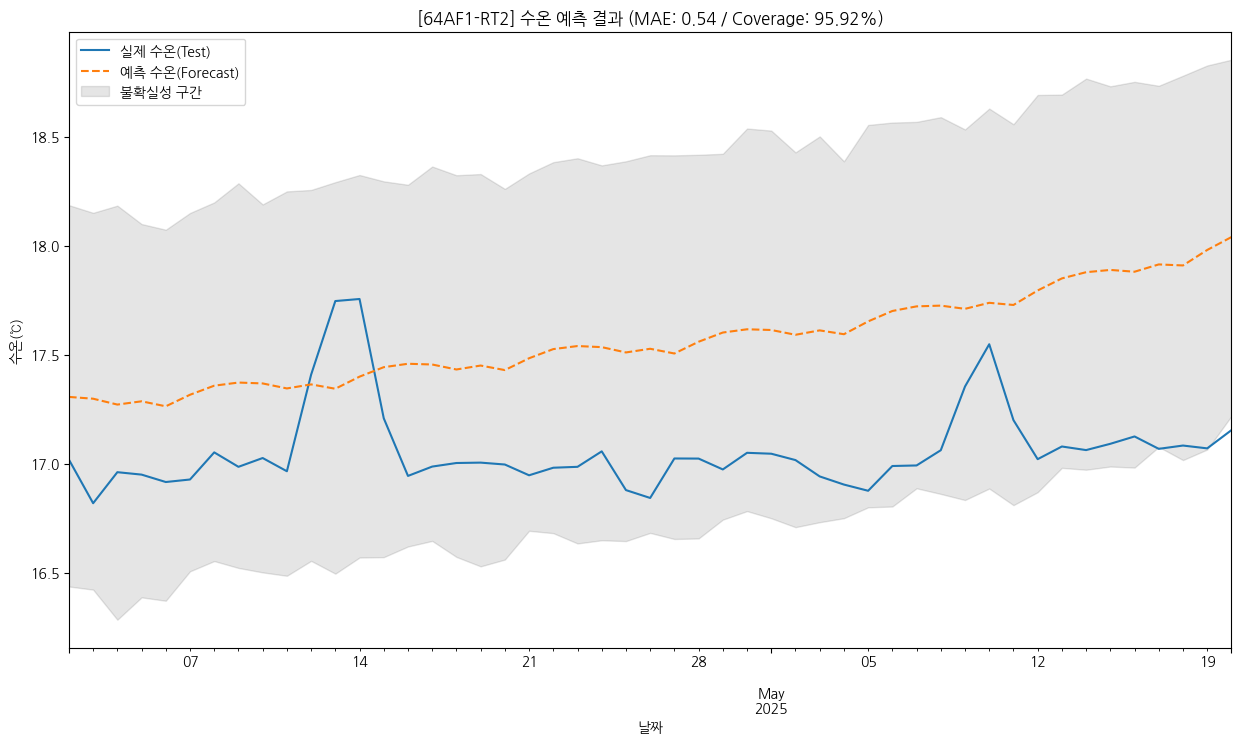

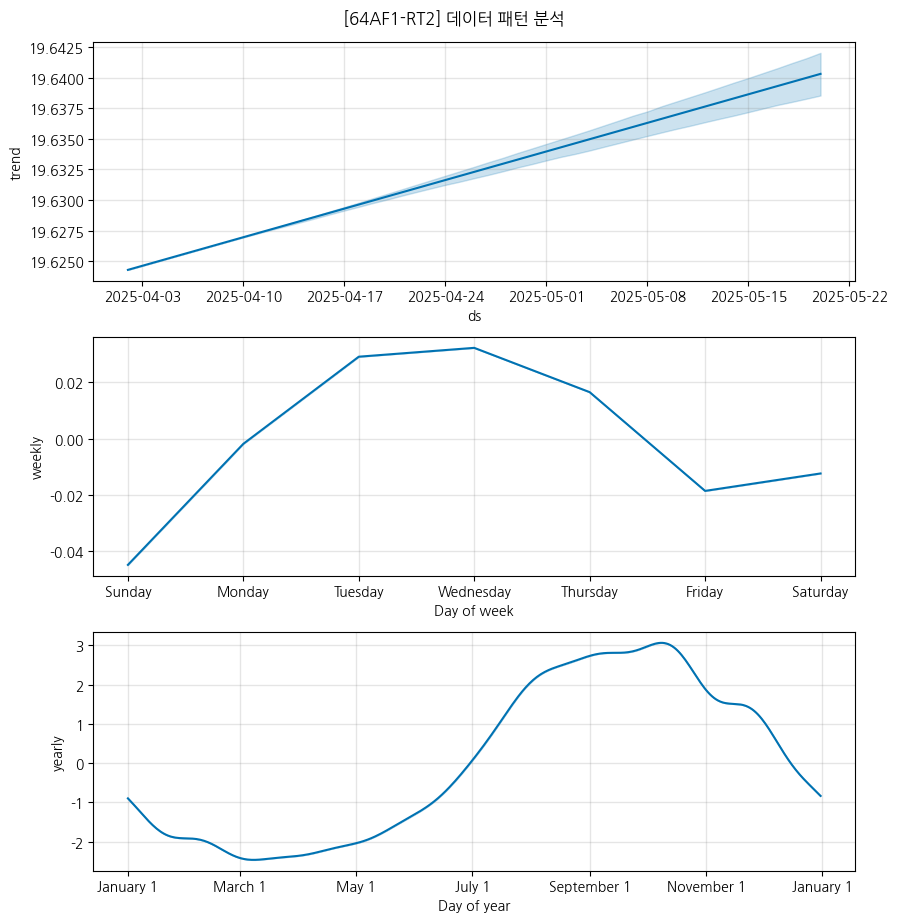

17:19:49 - cmdstanpy - INFO - Chain [1] start processing
17:19:49 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF2-IW1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 2.91
-> 예측 구간 내 실제값 포함 비율 (Coverage): 6.12%


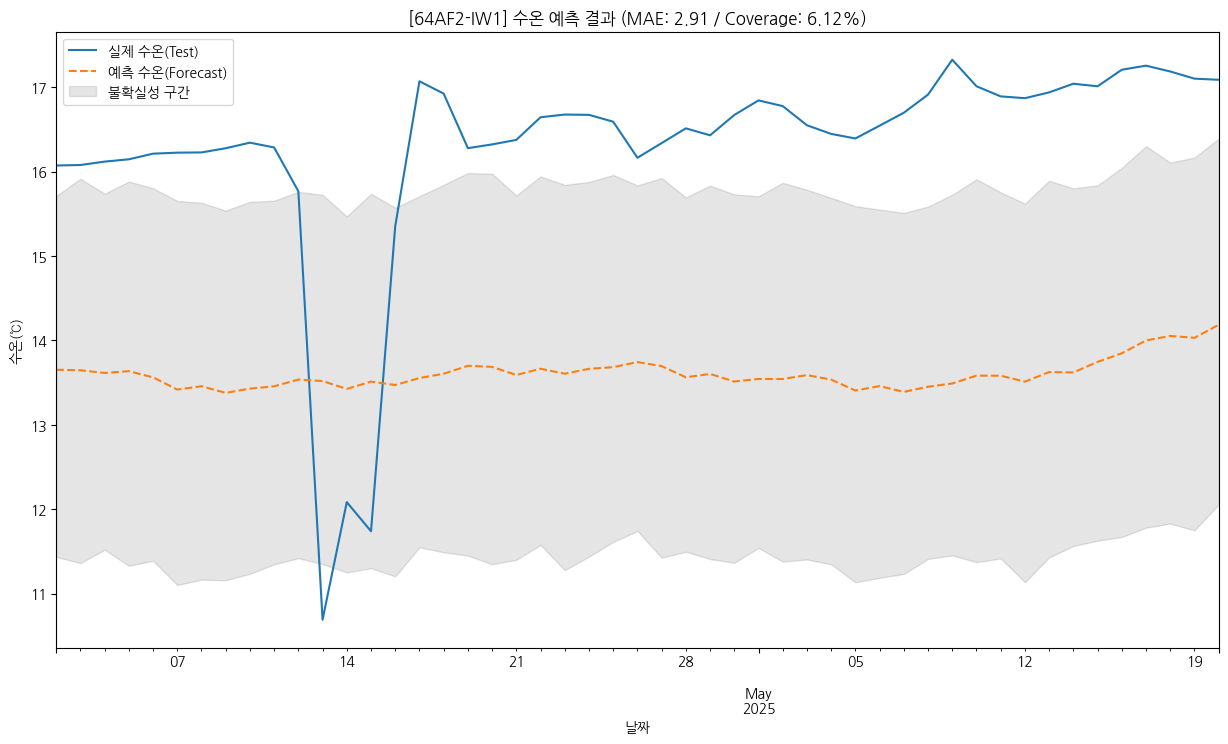

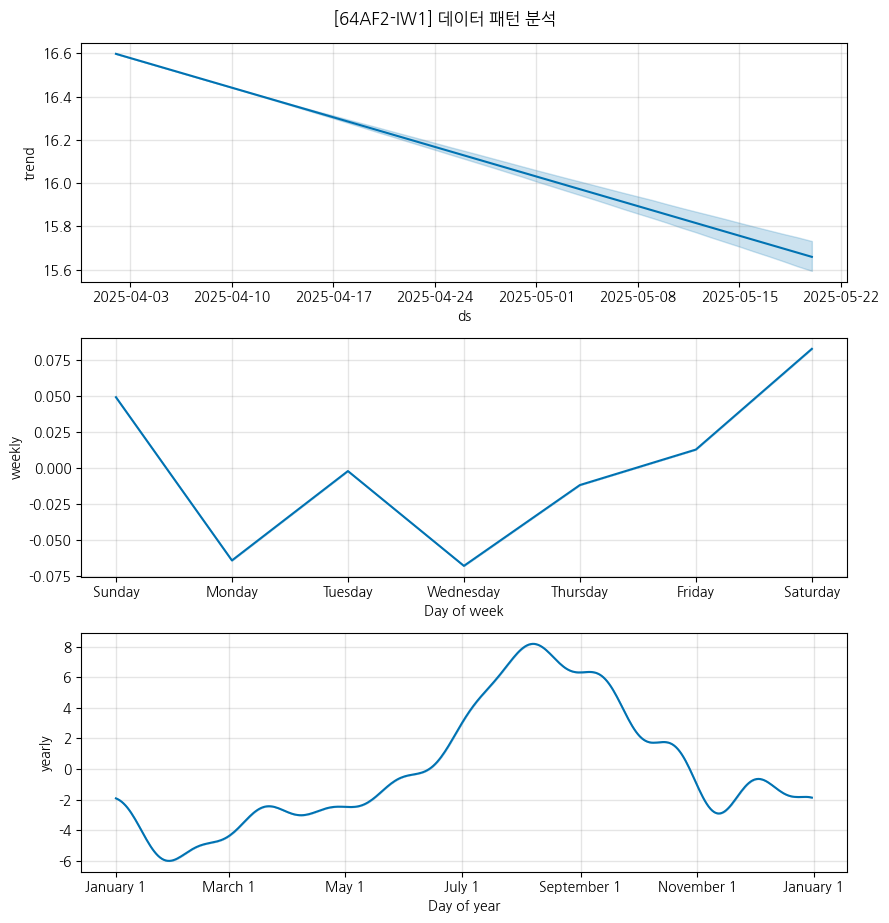

17:19:50 - cmdstanpy - INFO - Chain [1] start processing
17:19:50 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF2-RT1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.45
-> 예측 구간 내 실제값 포함 비율 (Coverage): 100.00%


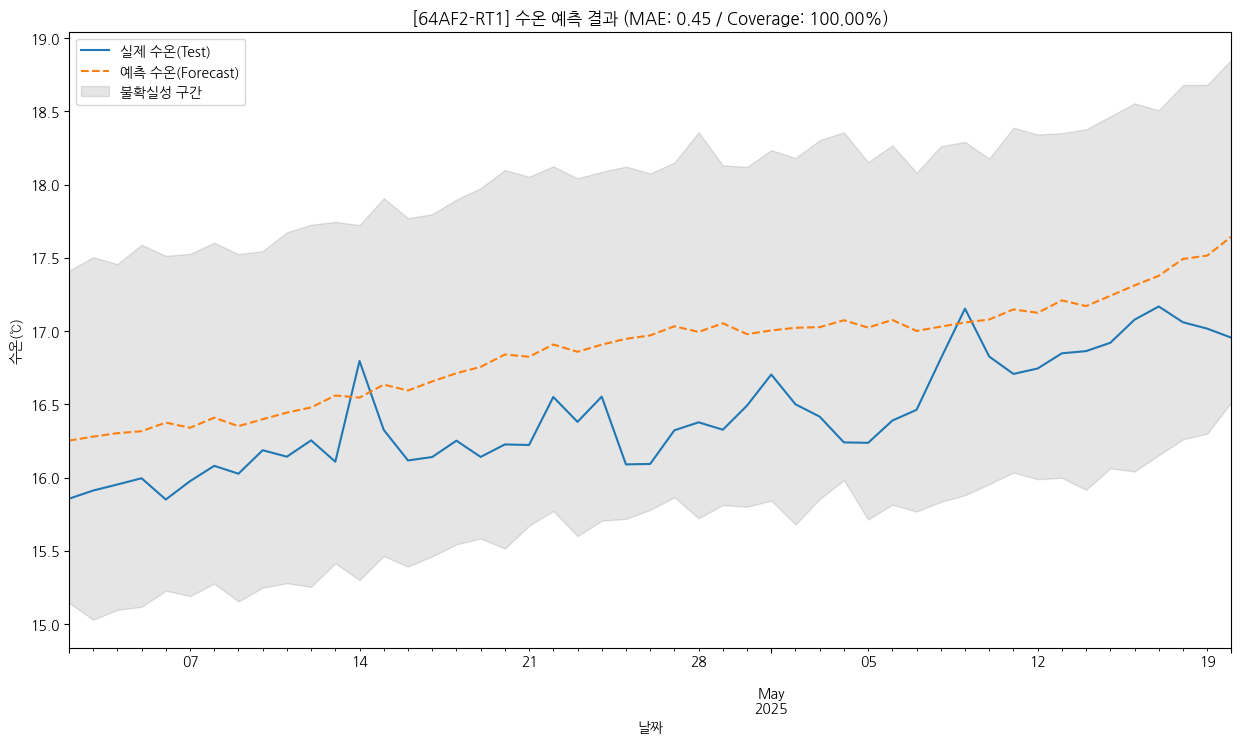

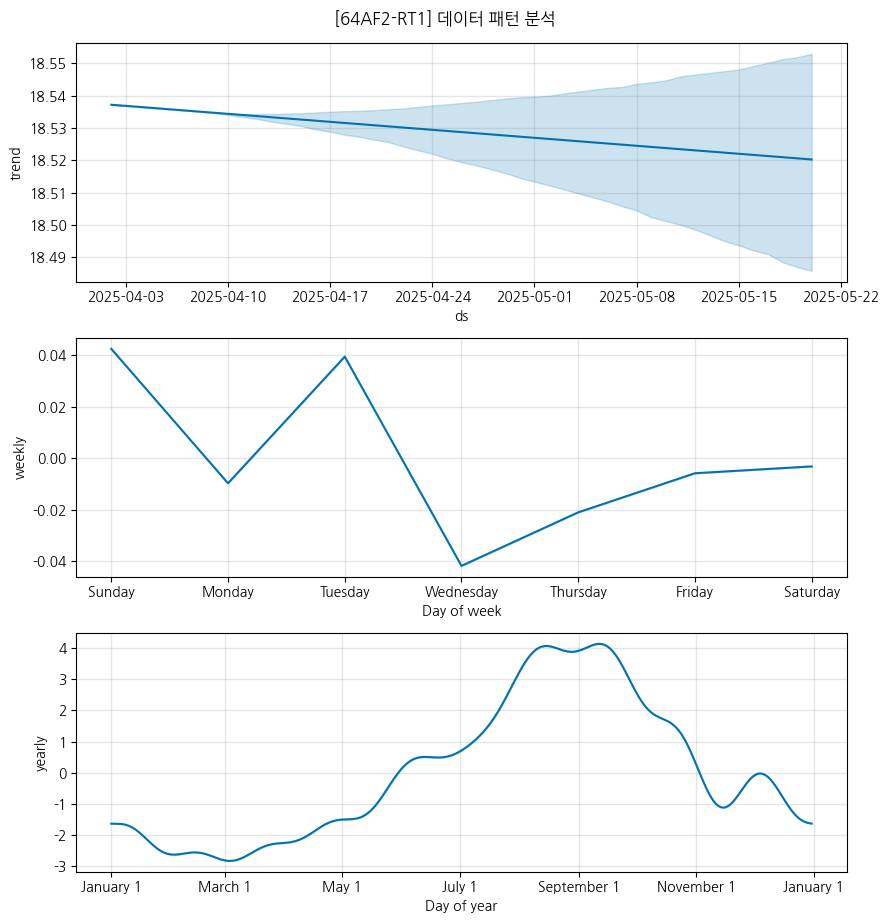

17:19:50 - cmdstanpy - INFO - Chain [1] start processing
17:19:50 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF2-RT2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.31
-> 예측 구간 내 실제값 포함 비율 (Coverage): 100.00%


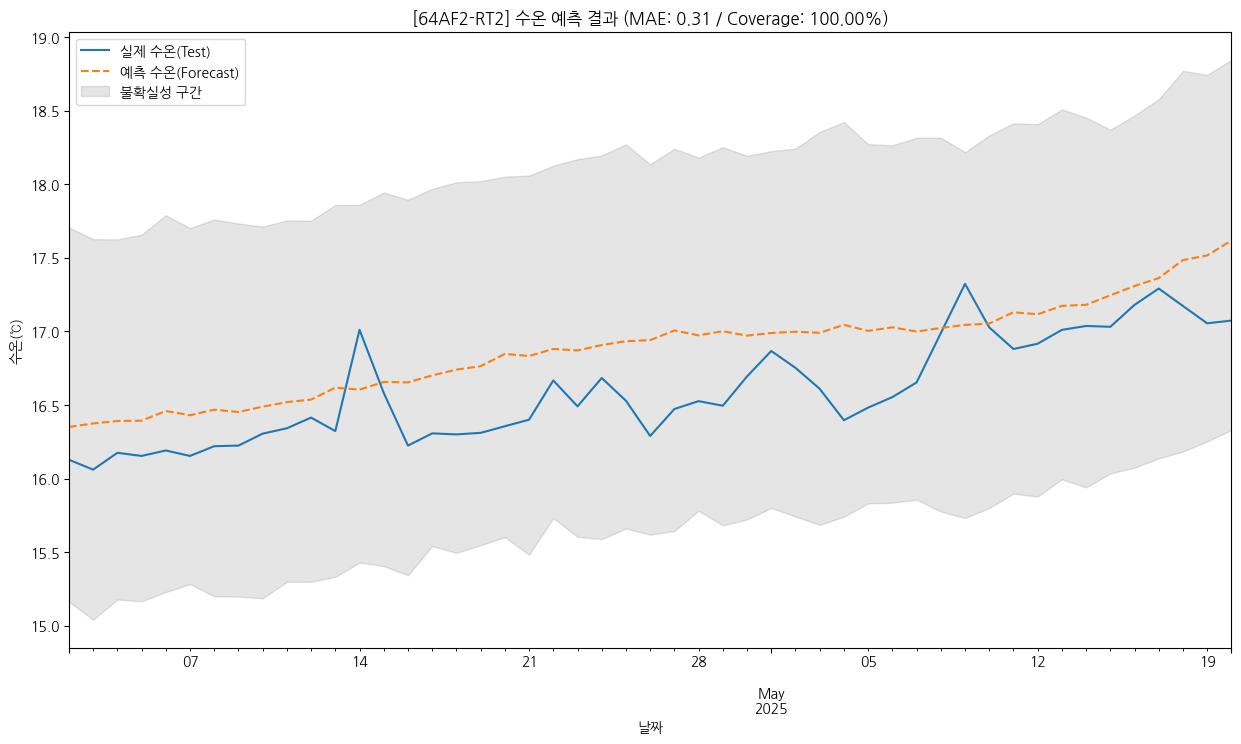

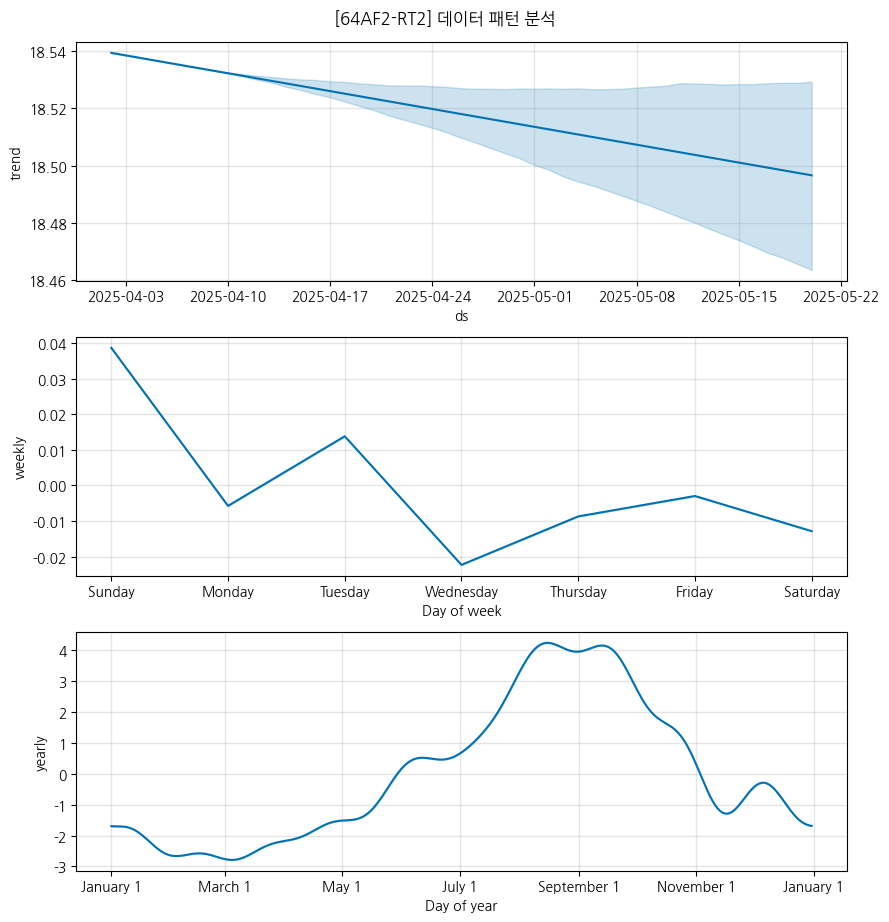

17:19:51 - cmdstanpy - INFO - Chain [1] start processing
17:19:51 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF3-IW1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.84
-> 예측 구간 내 실제값 포함 비율 (Coverage): 83.87%


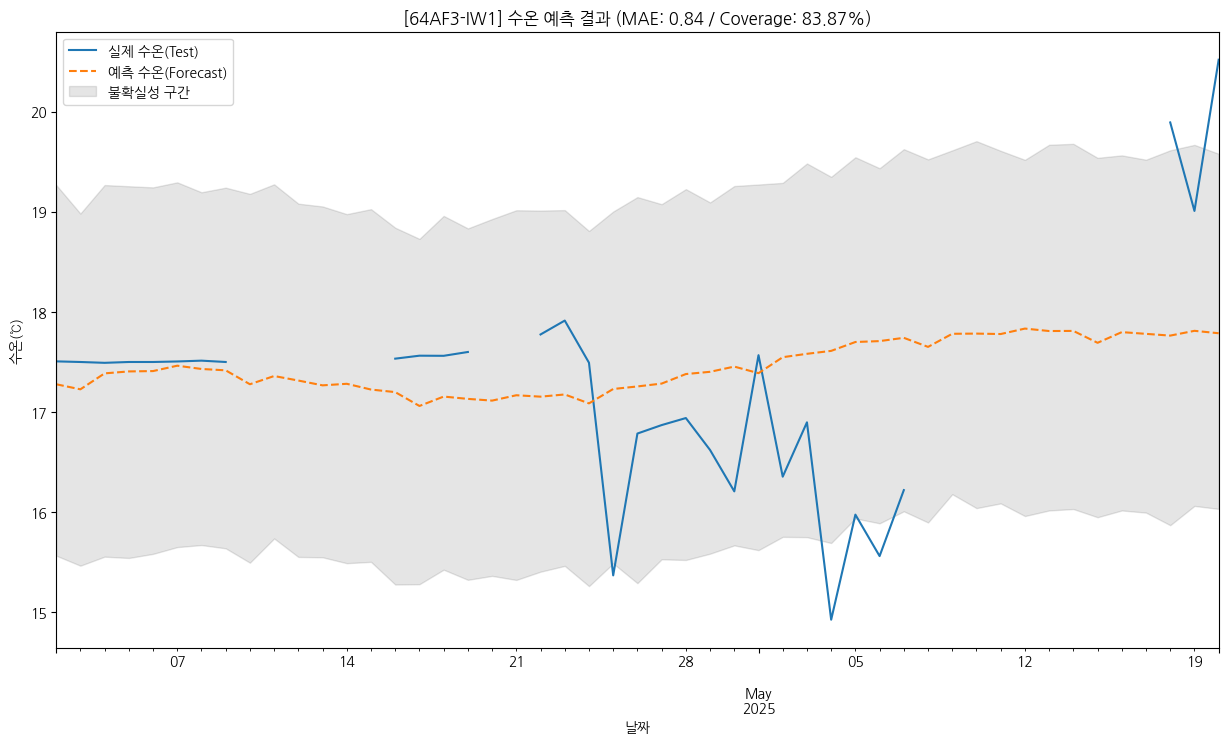

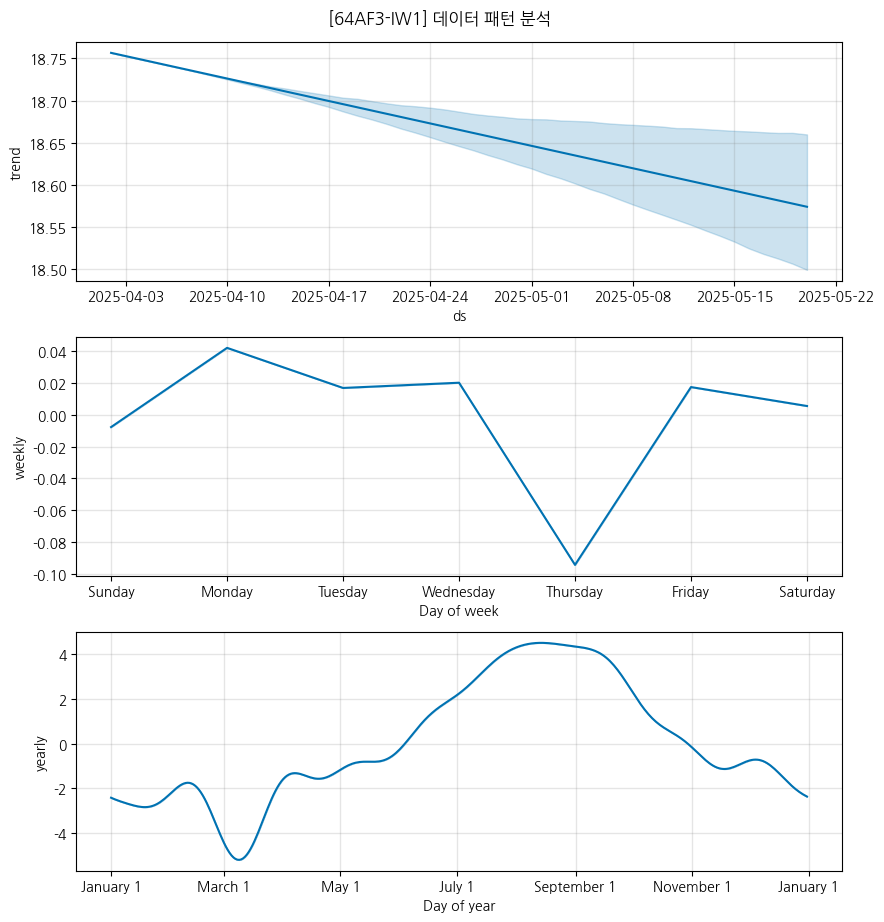

17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF3-RT1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 1.73
-> 예측 구간 내 실제값 포함 비율 (Coverage): 67.74%


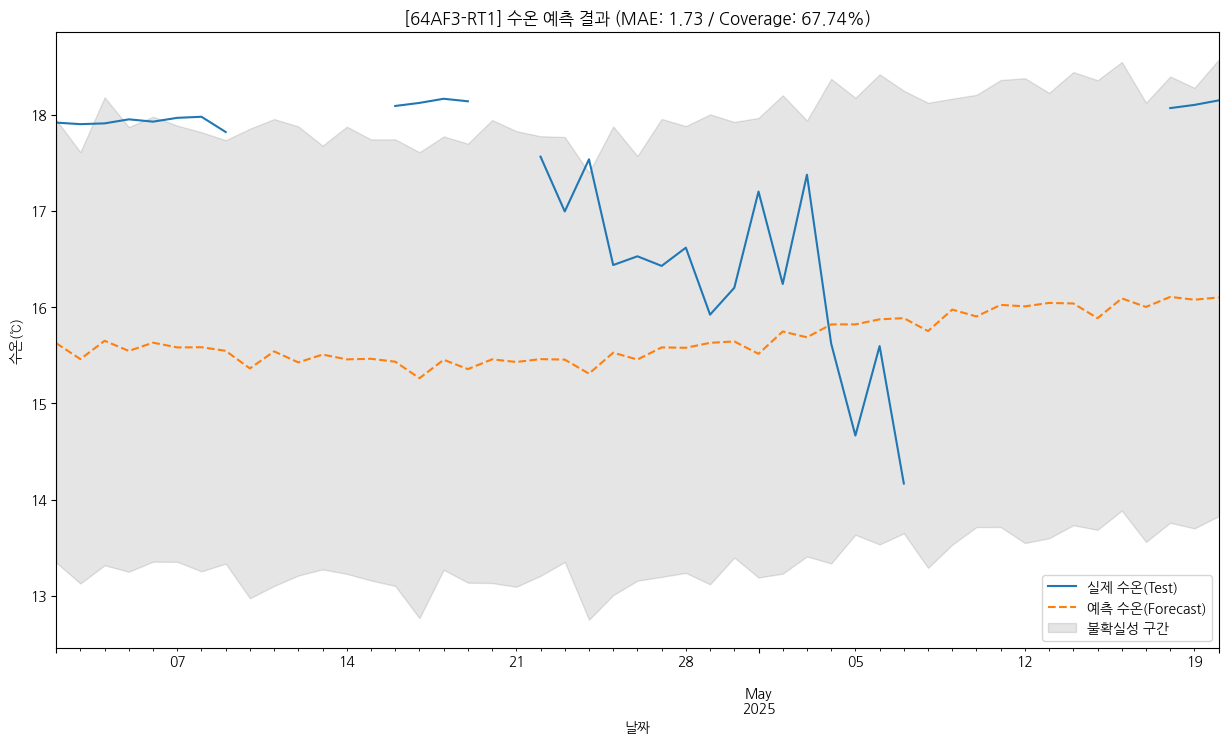

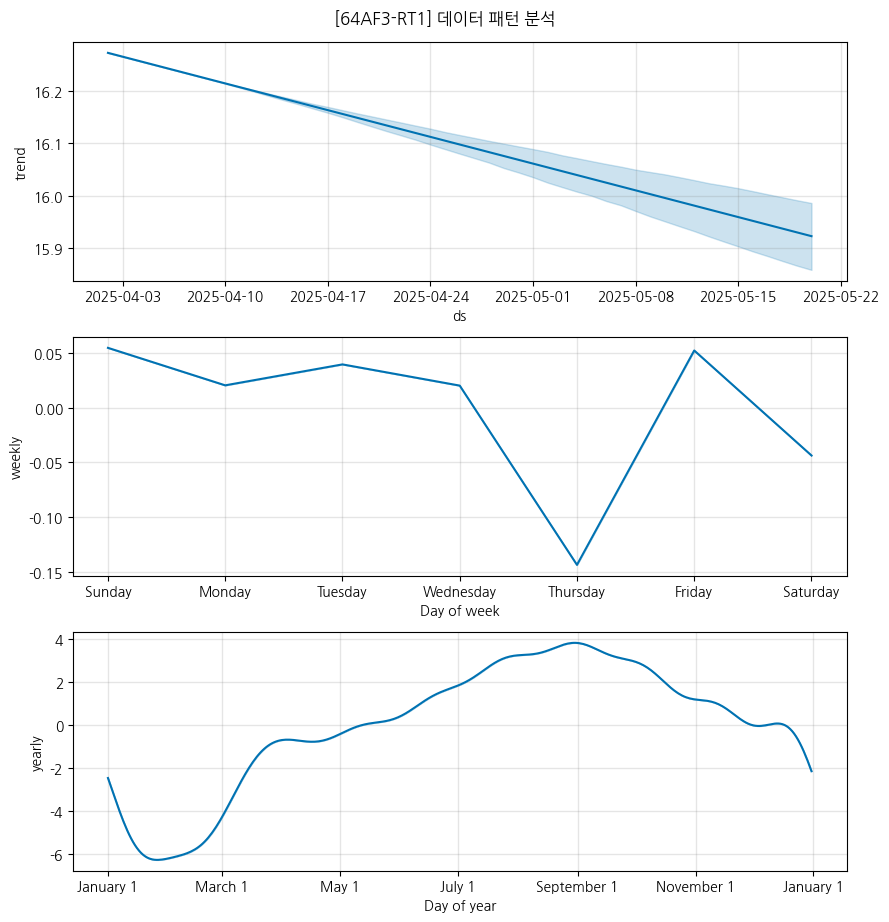

17:19:53 - cmdstanpy - INFO - Chain [1] start processing
17:19:53 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF3-RT2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 1.64
-> 예측 구간 내 실제값 포함 비율 (Coverage): 45.16%


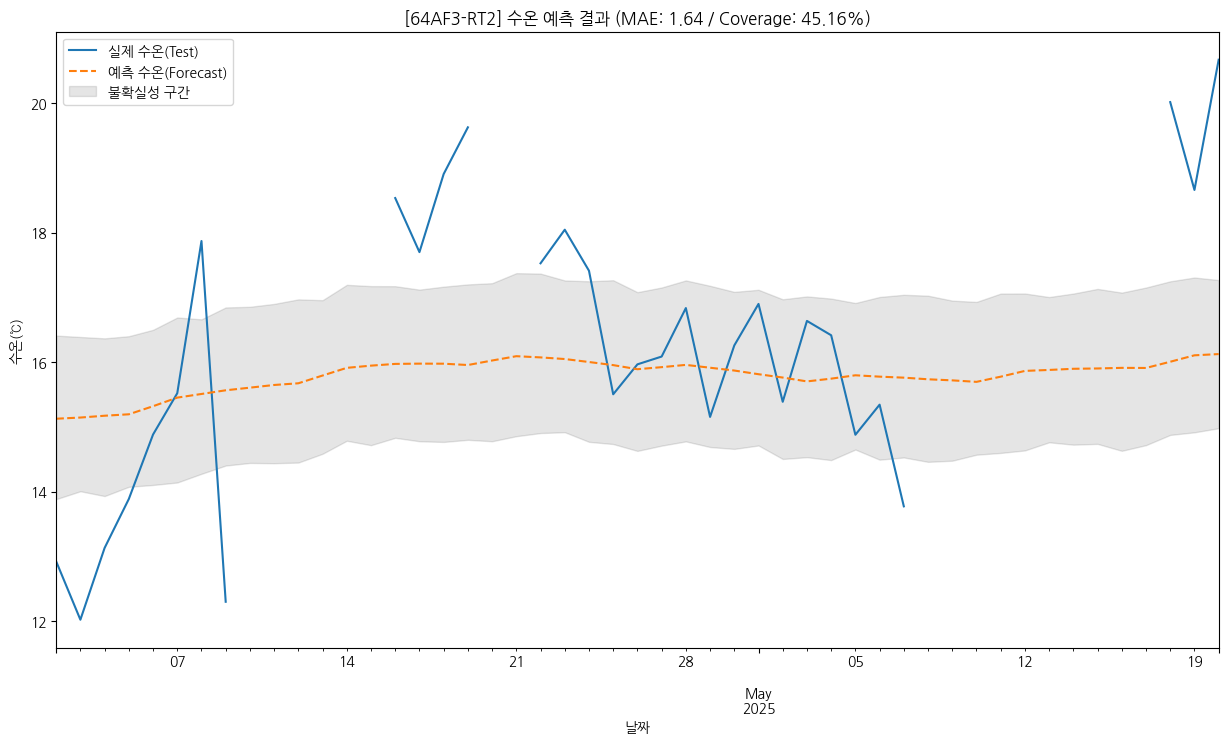

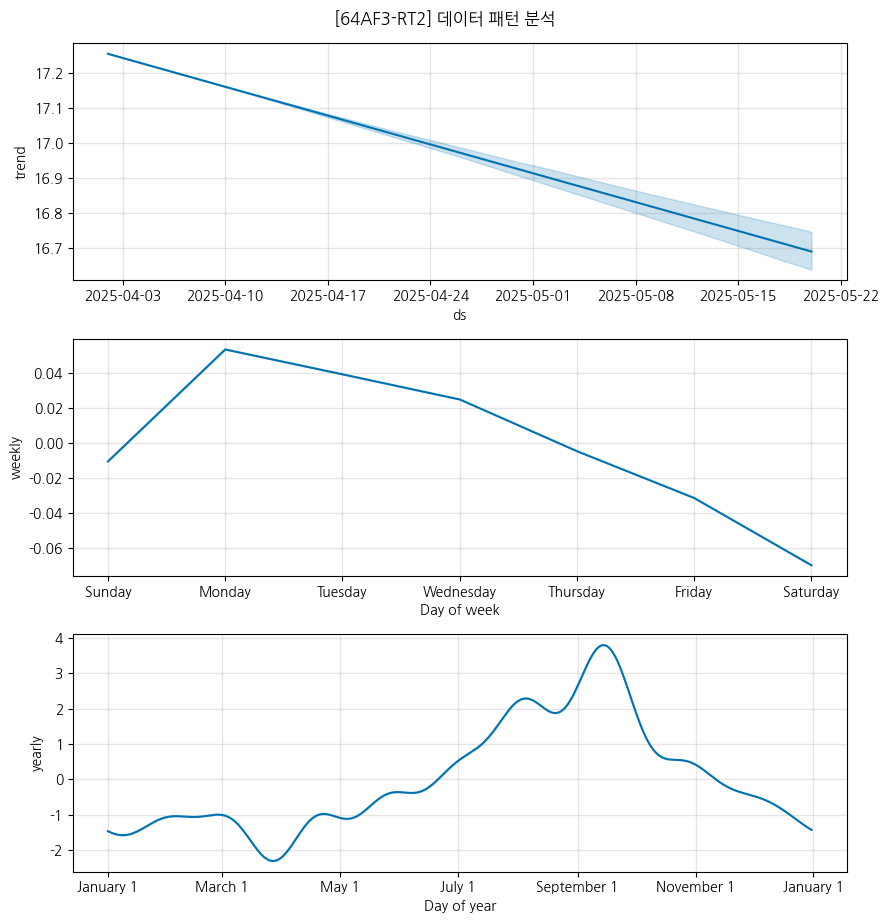

17:19:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------
===== 65AF1-IW1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 295개
테스트 데이터 개수: 49개


17:19:53 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 4.91
-> 예측 구간 내 실제값 포함 비율 (Coverage): 24.49%


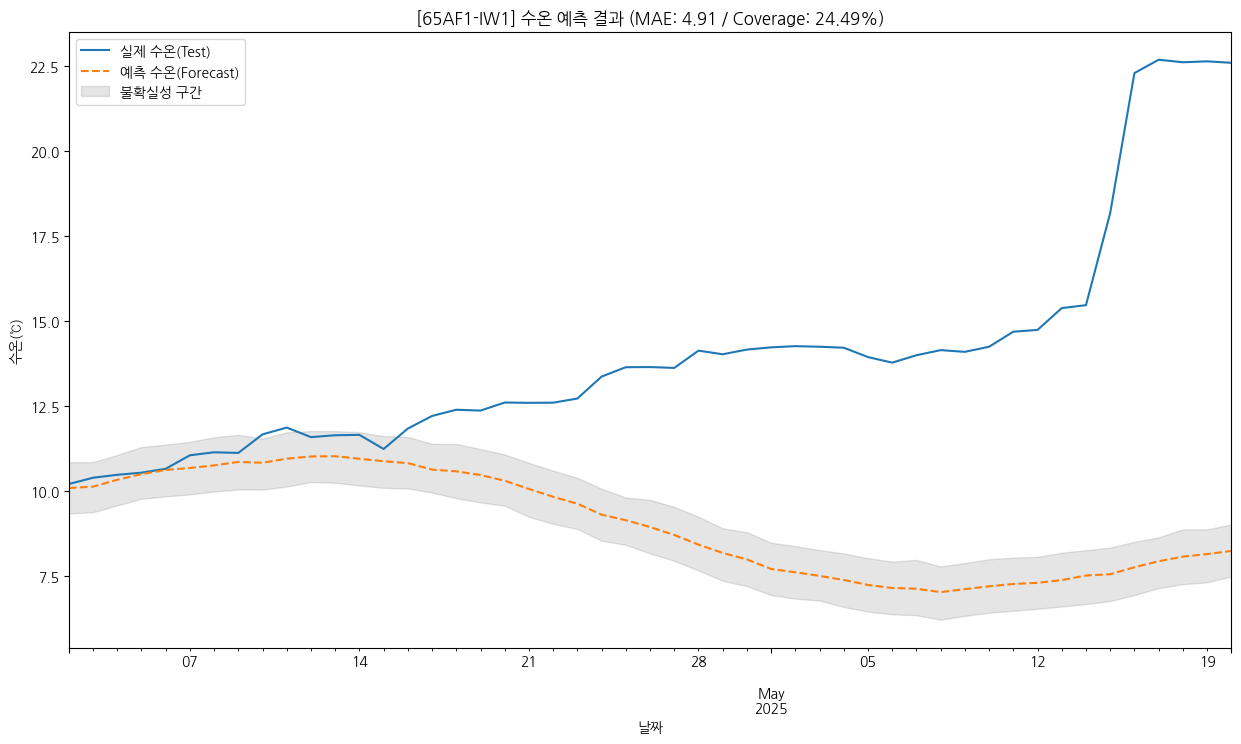

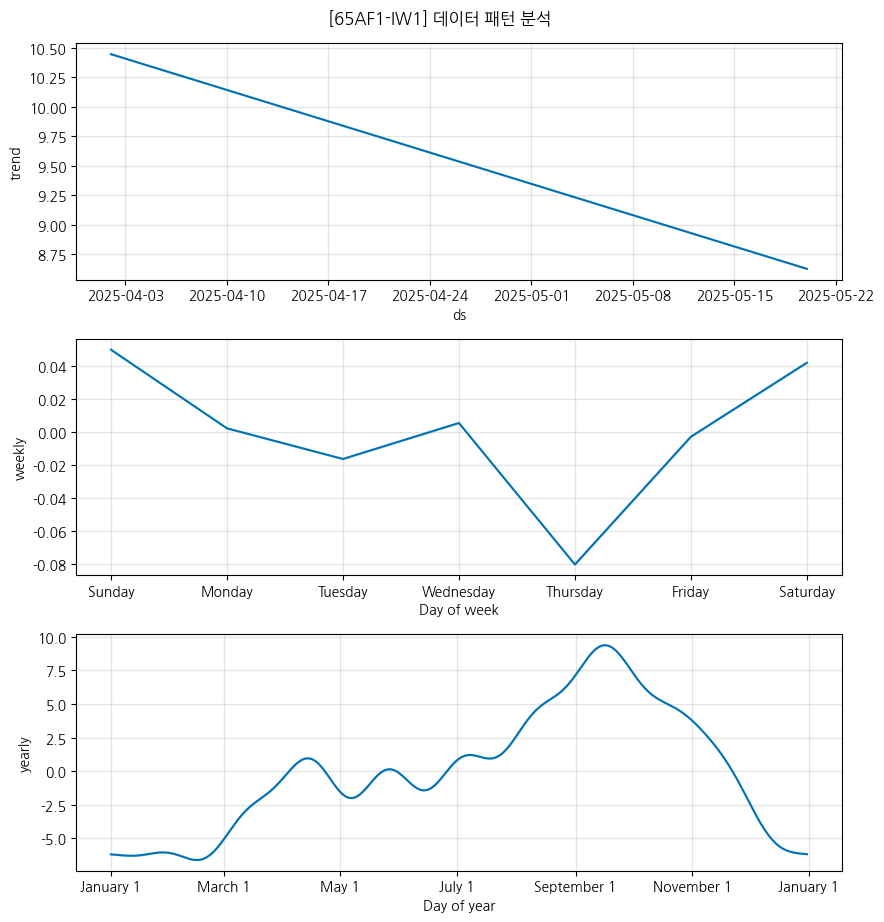

17:19:54 - cmdstanpy - INFO - Chain [1] start processing
17:19:54 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 65AF1-RT1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 295개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 6.33
-> 예측 구간 내 실제값 포함 비율 (Coverage): 2.04%


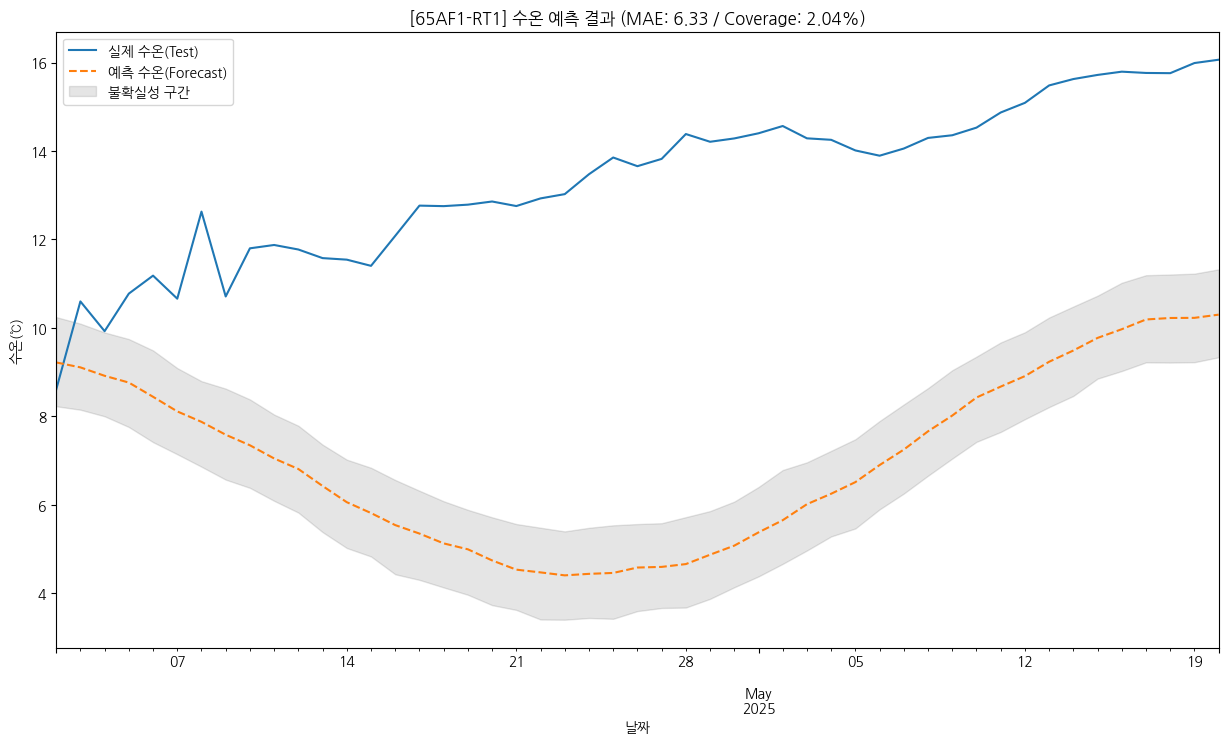

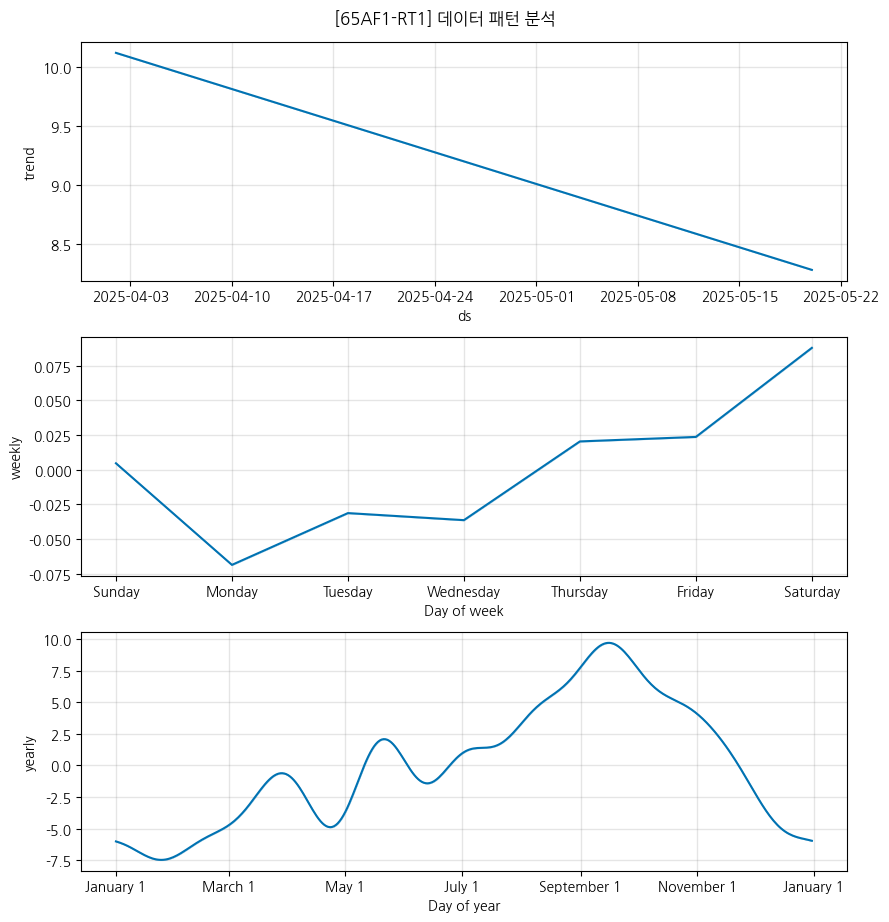

17:19:55 - cmdstanpy - INFO - Chain [1] start processing
17:19:55 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 65AF1-RT2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 295개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 5.31
-> 예측 구간 내 실제값 포함 비율 (Coverage): 8.16%


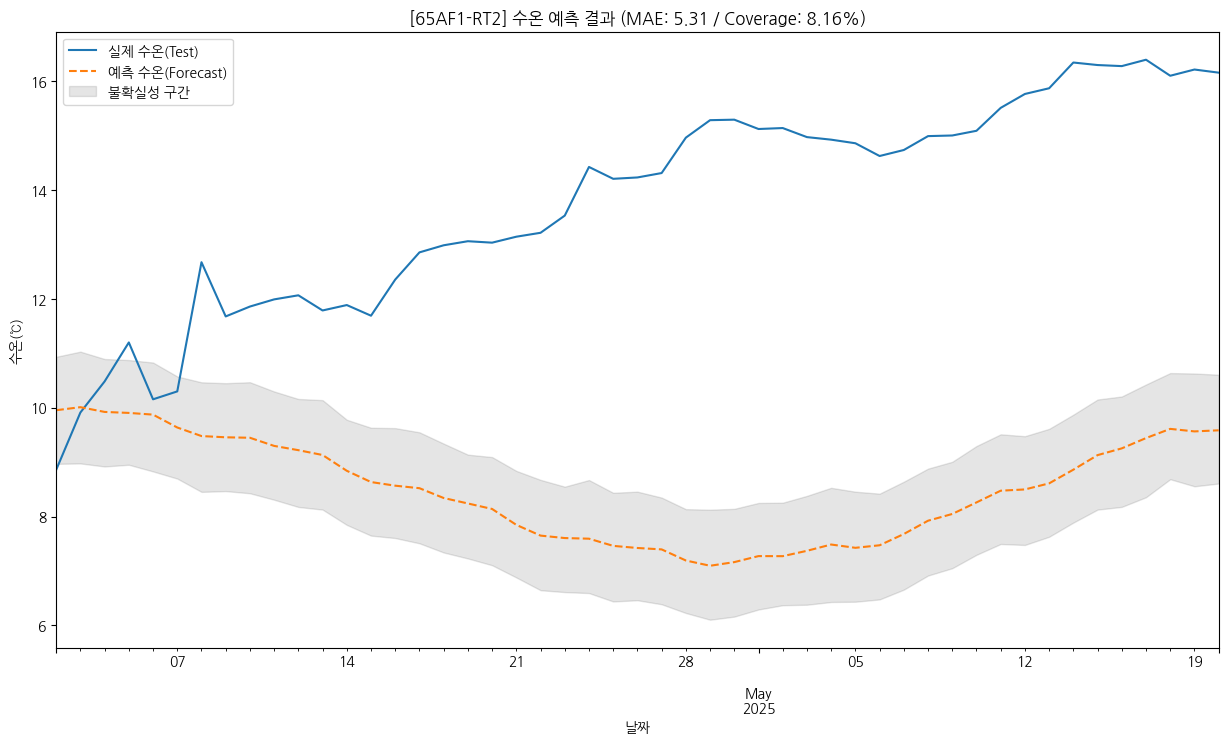

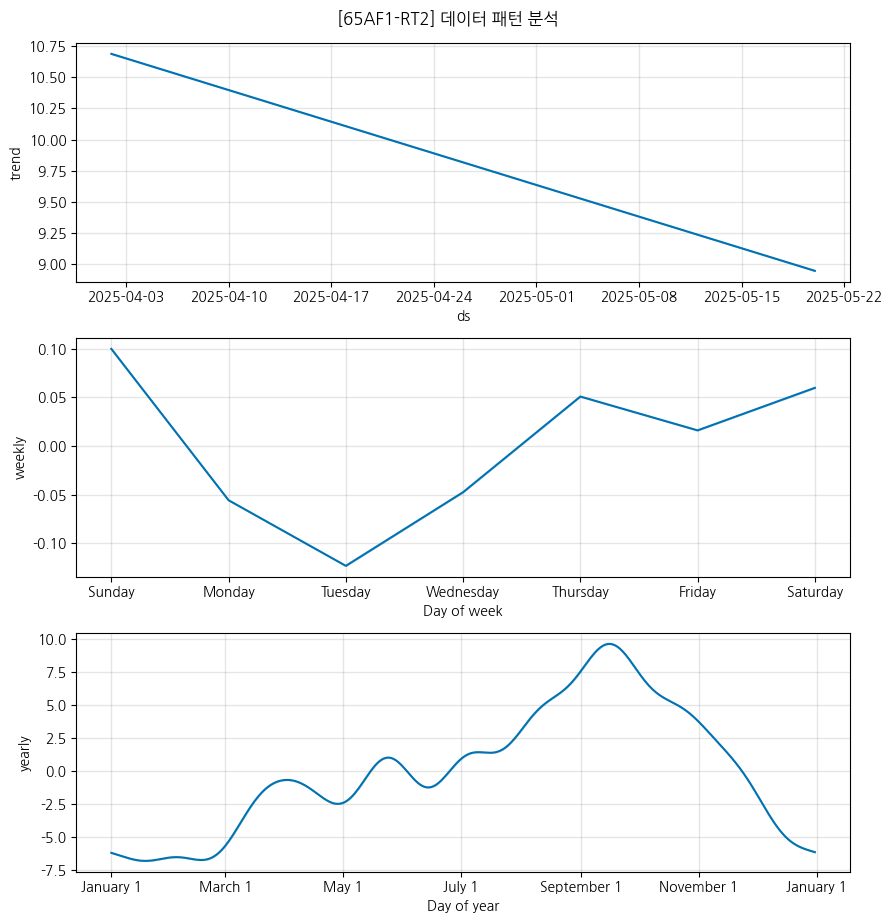

17:19:55 - cmdstanpy - INFO - Chain [1] start processing
17:19:55 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 65AF1-RT3 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 295개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 11.55
-> 예측 구간 내 실제값 포함 비율 (Coverage): 2.04%


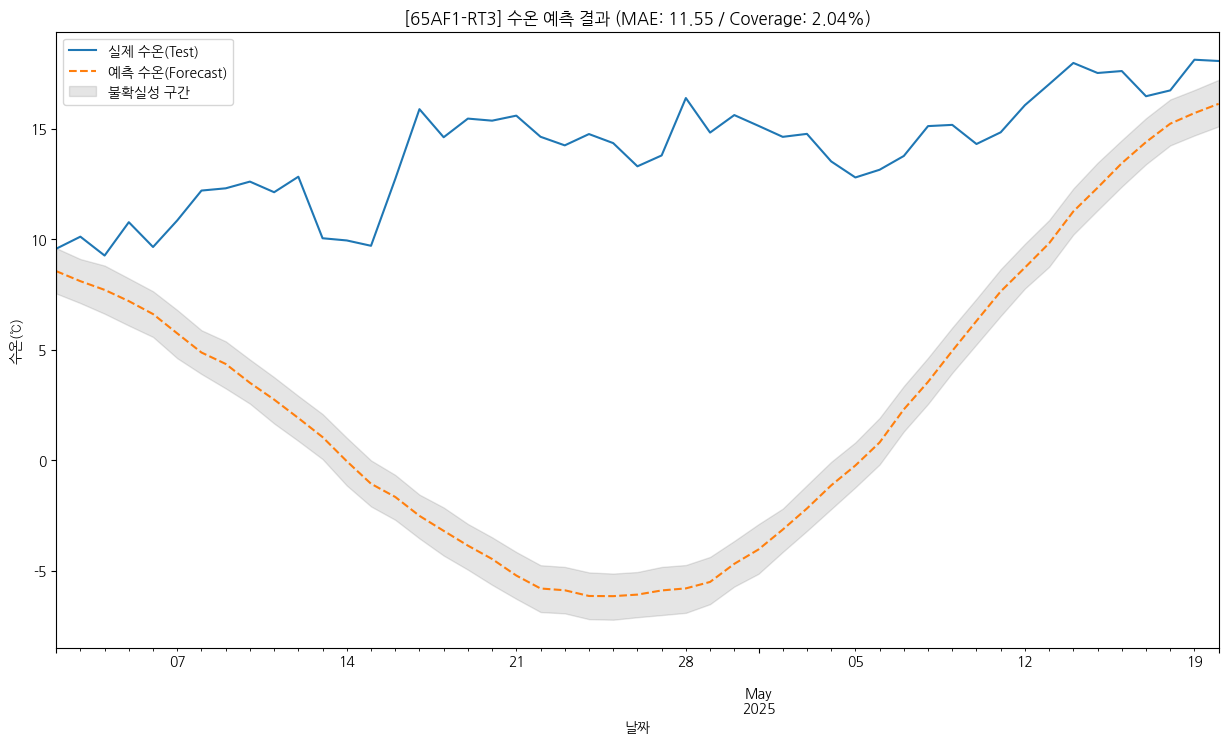

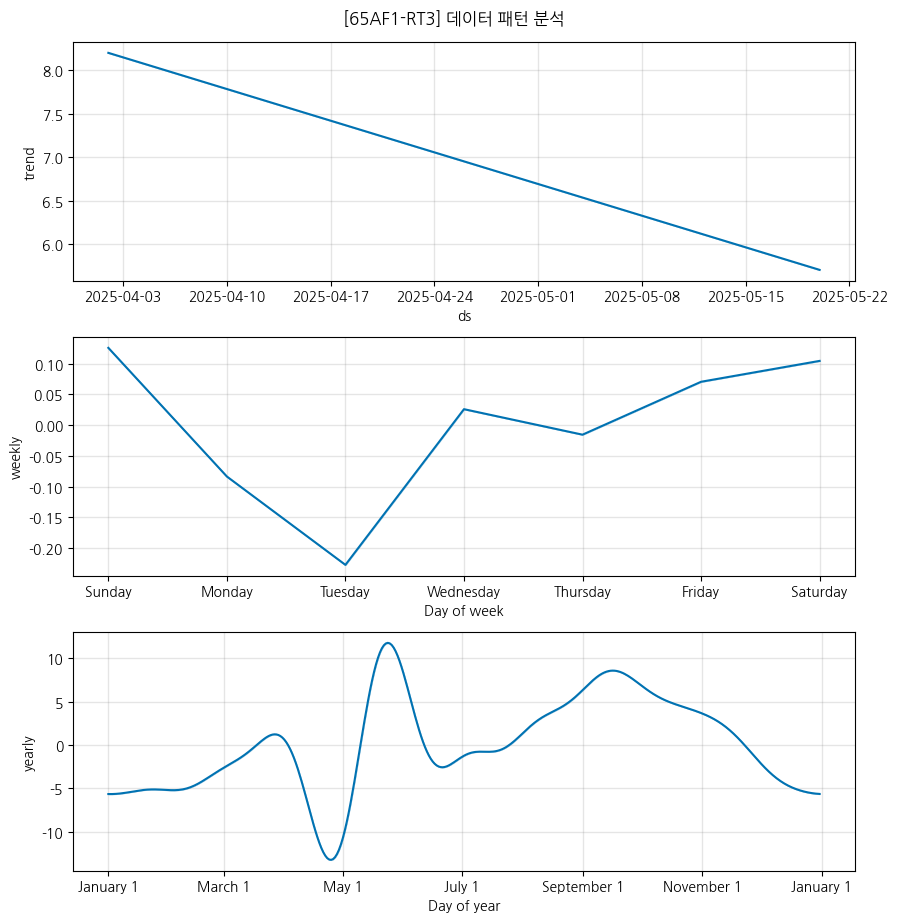

--------------------------------------------------
모든 시설에 대한 예측 및 분석이 완료되었습니다.


In [10]:
for fi in facility_id_list:
    print(f"===== {fi} 시설에 대한 예측을 시작합니다. =====")

    # 3-1. 데이터 선택 및 정렬
    select_df = temper_df[temper_df['시설 ID'] == fi]
    select_df = select_df.sort_index()

    # --- [추천] 일별 데이터로 리샘플링 ---
    # 'D'는 Daily frequency(일별 주기)를 의미합니다.
    # .mean()을 사용해 해당 날짜의 모든 수온 값의 평균을 그날의 대표 값으로 사용합니다.
    # 하루에 데이터가 한 번도 없는 날은 비어있는 값(NaN)으로 표시됩니다.
    daily_df = select_df[['수온(℃)']].resample('D').mean() 

    # [선택 사항] 리샘플링 후 비어있는 날(NaN)을 채워줍니다.
    # 예를 들어, 특정 날에 데이터 수집이 전혀 안 된 경우, 앞뒤 날짜의 평균값 등으로 채웁니다.
    # interpolate는 데이터의 흐름에 맞게 부드럽게 채워주는 유용한 기능입니다.
    #daily_df.interpolate(method='time', inplace=True)

    # 3-2. 학습용 / 테스트용 데이터 분리
    prophet_train = daily_df.loc[daily_df.index <= split_date].copy()
    prophet_test = daily_df.loc[daily_df.index > split_date].copy()

    # 3-3. 학습 데이터 유효성 검사
    print(f"학습 데이터 개수: {len(prophet_train)}개")
    print(f"테스트 데이터 개수: {len(prophet_test)}개")
    
    # [방어 코드 1] 학습 데이터가 너무 적으면(2개 미만) 모델이 학습할 수 없습니다.
    if len(prophet_train) < 2:
        print(f"-> [경고] 학습 데이터가 부족하여 이 시설의 예측을 건너뜁니다.\n")
        continue  # 다음 시설로 넘어감

    # [방어 코드 2] 테스트 데이터가 없으면 예측 성능을 평가하고 비교할 수 없습니다.
    if len(prophet_test) == 0:
        print(f"-> [경고] 테스트 데이터가 없어 예측 성능 평가를 할 수 없으므로 건너뜁니다.\n")
        continue # 다음 시설로 넘어감

    # 3-4. Prophet을 위한 데이터 준비
    prophet_train.reset_index(inplace=True)
    prophet_train.rename(columns={'일시': 'ds', '수온(℃)': 'y'}, inplace=True)

    # 이상치(Outlier)를 제거
    outlier_count = prophet_train[(prophet_train['y'] > 35) | (prophet_train['y'] < 0)].shape[0]
    if outlier_count > 0:
        print(f"-> {outlier_count}개의 이상치를 감지하여 학습에서 제외합니다.")
        prophet_train.loc[(prophet_train['y'] > 35) | (prophet_train['y'] < 0), 'y'] = np.nan

    # 3-5. Prophet 모델 학습 및 예측
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_train)
    future = prophet_test.reset_index().rename(columns={'일시': 'ds'})[['ds']]
    try:
        forecast = model.predict(future)
    except Exception as e:
        print(prophet_train)
        print(f"-> 예측 중 오류 발생: {e}. 예측을 건너뜁니다.\n")
        continue

    # 3-6. 결과 분석 및 시각화
    comparison_df = prophet_test.copy()
    comparison_df['forecast'] = forecast['yhat'].values
    # Coverage 계산을 위해 lower/upper 바운드도 추가
    comparison_df['forecast_lower'] = forecast['yhat_lower'].values
    comparison_df['forecast_upper'] = forecast['yhat_upper'].values

    # 2. '수온(℃)' 또는 'forecast' 컬럼에 NaN이 있는 모든 행을 통째로 제거합니다.
    #    이렇게 하면 두 데이터의 길이가 정확히 맞춰집니다.
    comparison_df.dropna(subset=['수온(℃)'], inplace=True)

    # 3. 이제 NaN이 없는 깨끗한 데이터로 안전하게 MAE를 계산합니다.
    #    오류가 발생했던 아래 라드를 이렇게 수정합니다.
    if not comparison_df.empty:
        mae = mean_absolute_error(comparison_df['수온(℃)'], comparison_df['forecast'])
        print(f"-> 예측 평균 절대 오차(MAE): {mae:.2f}")
    else:
        mae = 'N/A' # 계산 불가
        print("-> MAE를 계산할 데이터가 없습니다.")
    
    if not comparison_df.empty:
        # 실제값이 예측 범위(lower ~ upper) 내에 있는지 확인 (True/False)
        comparison_df['in_bounds'] = (comparison_df['수온(℃)'] >= comparison_df['forecast_lower']) & \
                                        (comparison_df['수온(℃)'] <= comparison_df['forecast_upper'])
        
        # True의 비율을 계산하여 백분율로 변환
        coverage = comparison_df['in_bounds'].mean() * 100
        print(f"-> 예측 구간 내 실제값 포함 비율 (Coverage): {coverage:.2f}%")
    else:
        coverage = 'N/A'

    fig, ax = plt.subplots(figsize=(15, 8))
    prophet_test['수온(℃)'].plot(ax=ax, label='실제 수온(Test)', style='-')
    forecast.set_index('ds')['yhat'].plot(ax=ax, label='예측 수온(Forecast)', style='--')
    ax.fill_between(forecast['ds'].values, forecast['yhat_lower'].values, forecast['yhat_upper'].values, color='k', alpha=0.1, label='불확실성 구간')
    
    # 제목에 MAE와 Coverage를 함께 표시
    mae_str = f"{mae:.2f}" if isinstance(mae, float) else mae
    coverage_str = f"{coverage:.2f}%" if isinstance(coverage, float) else coverage
    ax.set_title(f'[{fi}] 수온 예측 결과 (MAE: {mae_str} / Coverage: {coverage_str})')
    
    ax.set_xlabel('날짜')
    ax.set_ylabel('수온(℃)')
    plt.legend()
    
    # 파일 경로 생성 및 저장
    location_code_for_path = fi[:5]
    location_folder = os.path.join(main_figure_folder, location_code_for_path)
    os.makedirs(location_folder, exist_ok=True)
    filepath = os.path.join(location_folder, f"{fi}_forecast.png")
    plt.savefig(filepath)
    plt.show()

    # 패턴 분석 그래프 저장
    model.plot_components(forecast)
    plt.suptitle(f'[{fi}] 데이터 패턴 분석', y=1.02)
    filepath = os.path.join(location_folder, f"{fi}_components.png")
    plt.savefig(filepath)
    plt.show()
    
    print("-" * 50)

print("모든 시설에 대한 예측 및 분석이 완료되었습니다.")

# 4단계: 시설 데이터 유사도 분석

## 0단계: 필요한 라이브러리 및 데이터 준비

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("데이터가 준비되었다고 가정하고 분석을 시작합니다.")

데이터가 준비되었다고 가정하고 분석을 시작합니다.


## 1단계: 데이터 그룹핑을 위한 '시설 코드' 생성

In [12]:
# '시설 ID'에서 앞 5자리를 추출하여 '시설 코드'라는 새로운 컬럼을 만듭니다.
# 이 코드는 이미 temper_df에 '시설 코드'가 없는 경우에만 실행합니다.
if '시설 코드' not in temper_df.columns:
    temper_df['시설 코드'] = temper_df['시설 ID'].str.slice(start=0, stop=5)

# 분석할 고유한 시설 코드 목록을 가져옵니다.
location_codes = temper_df['시설 코드'].unique()

print(f"분석할 고유 시설 코드: {len(location_codes)}개")

분석할 고유 시설 코드: 6개


## 2단계: 시각적 유사도 분석

각 시설 내 수조별 데이터 추이를 시각적으로 비교합니다...


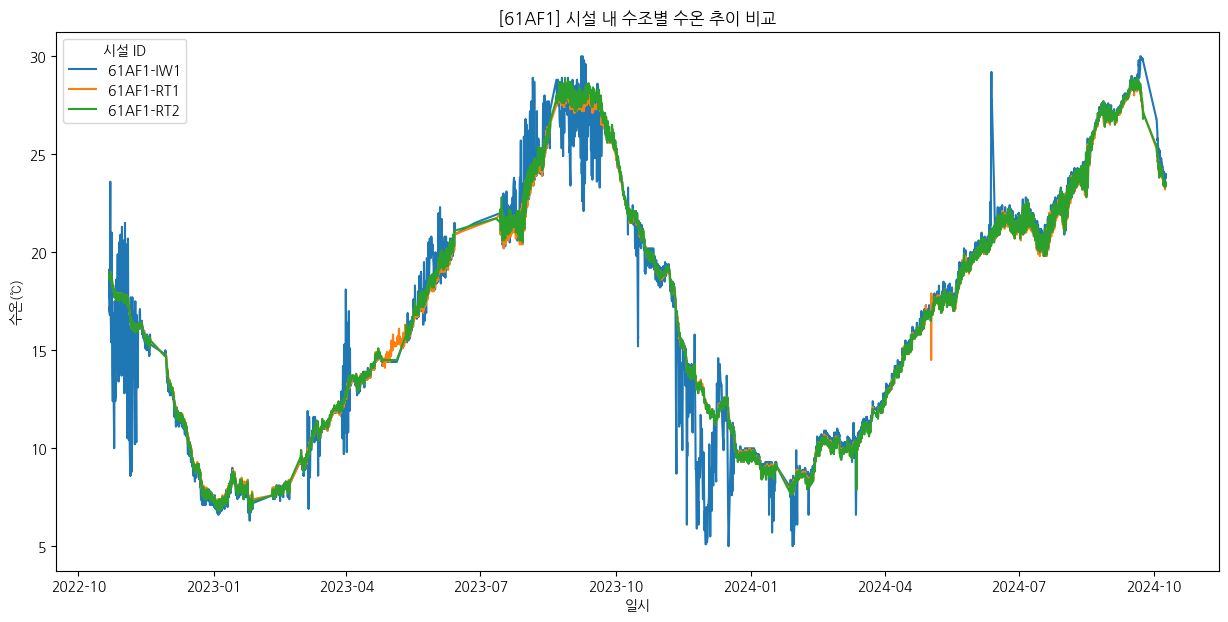

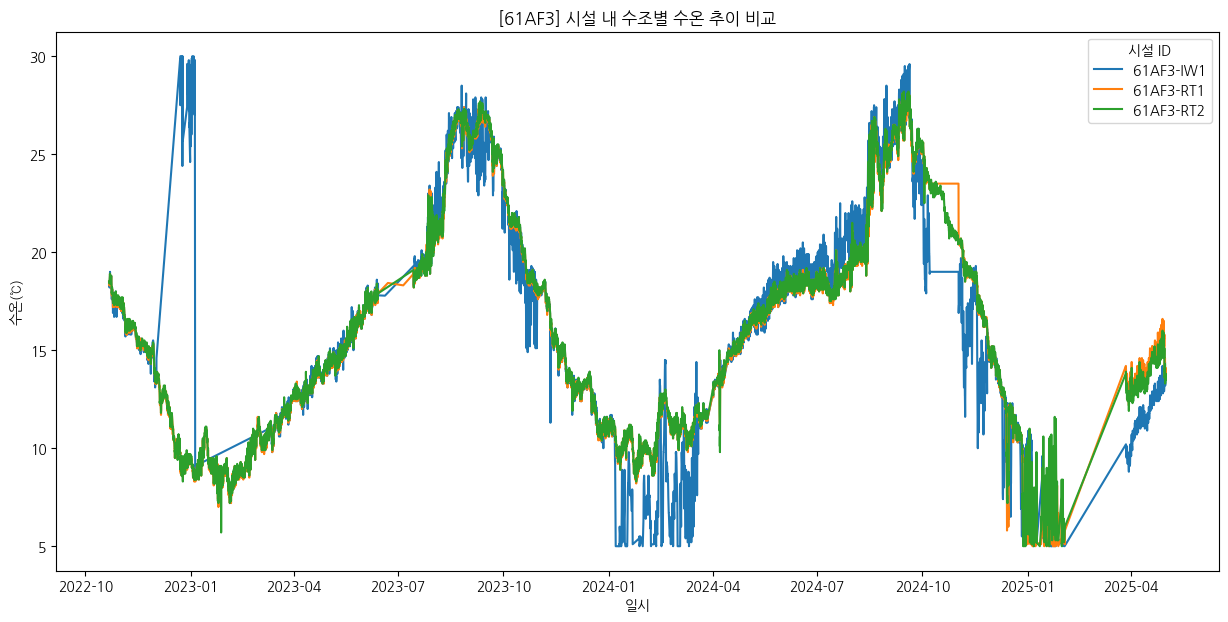

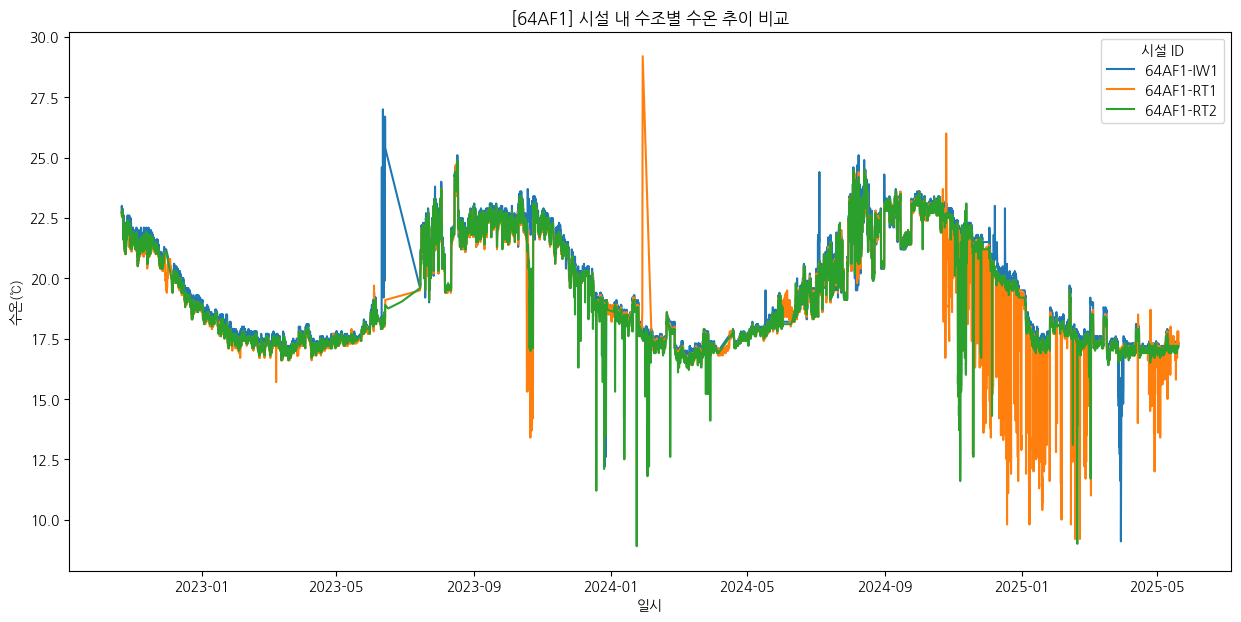

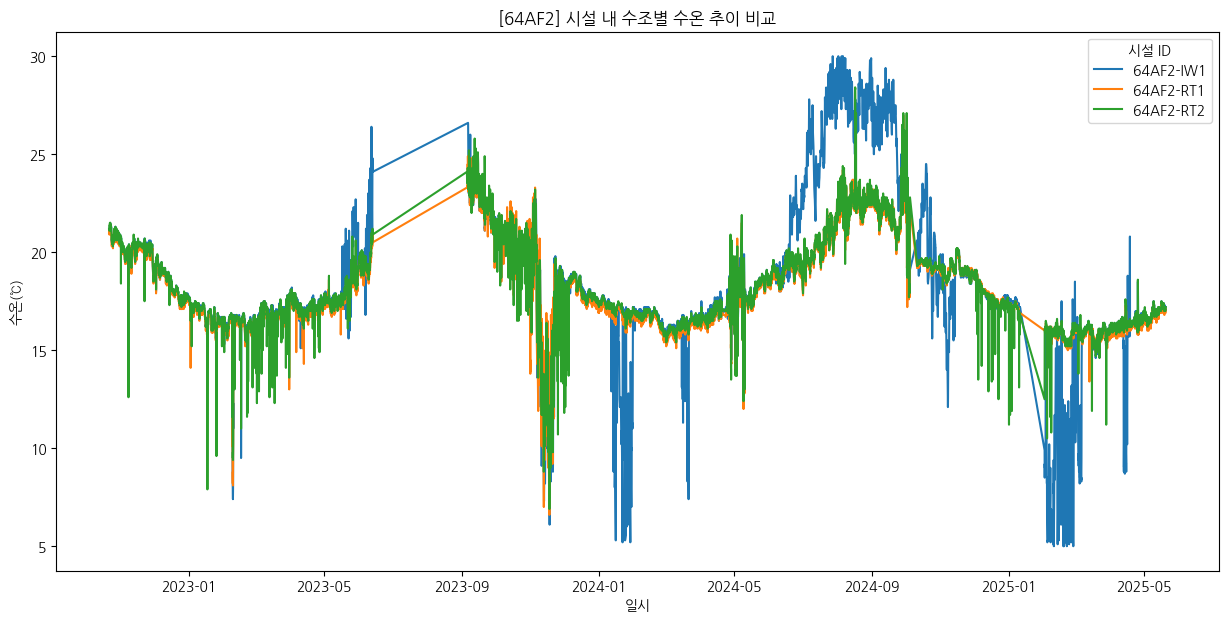

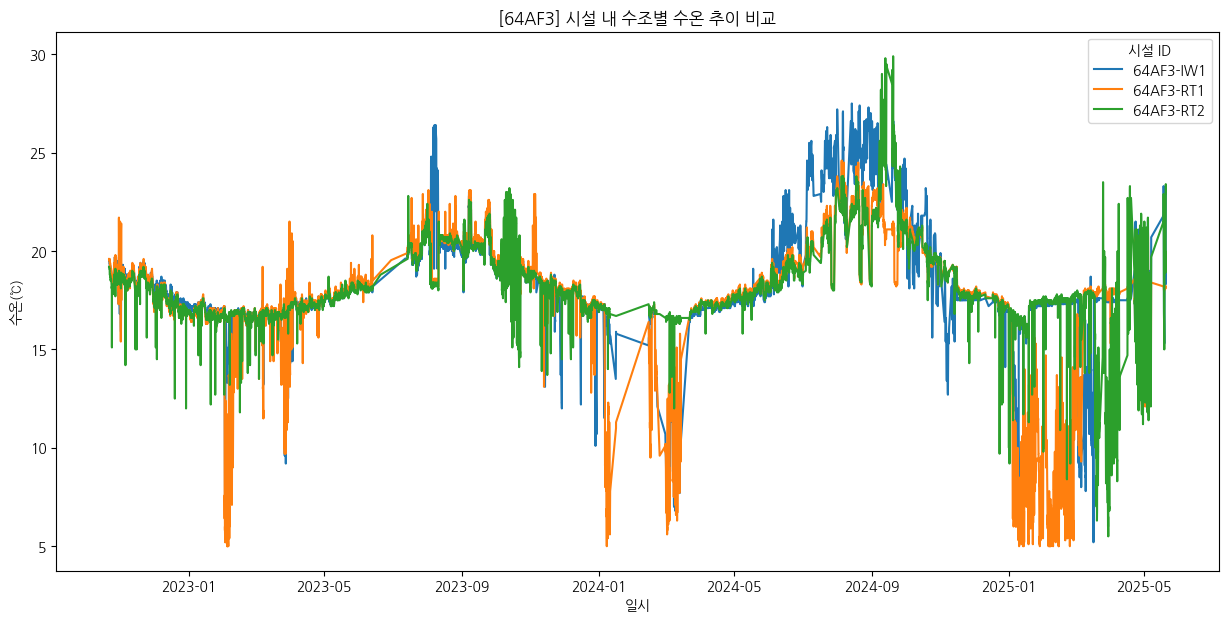

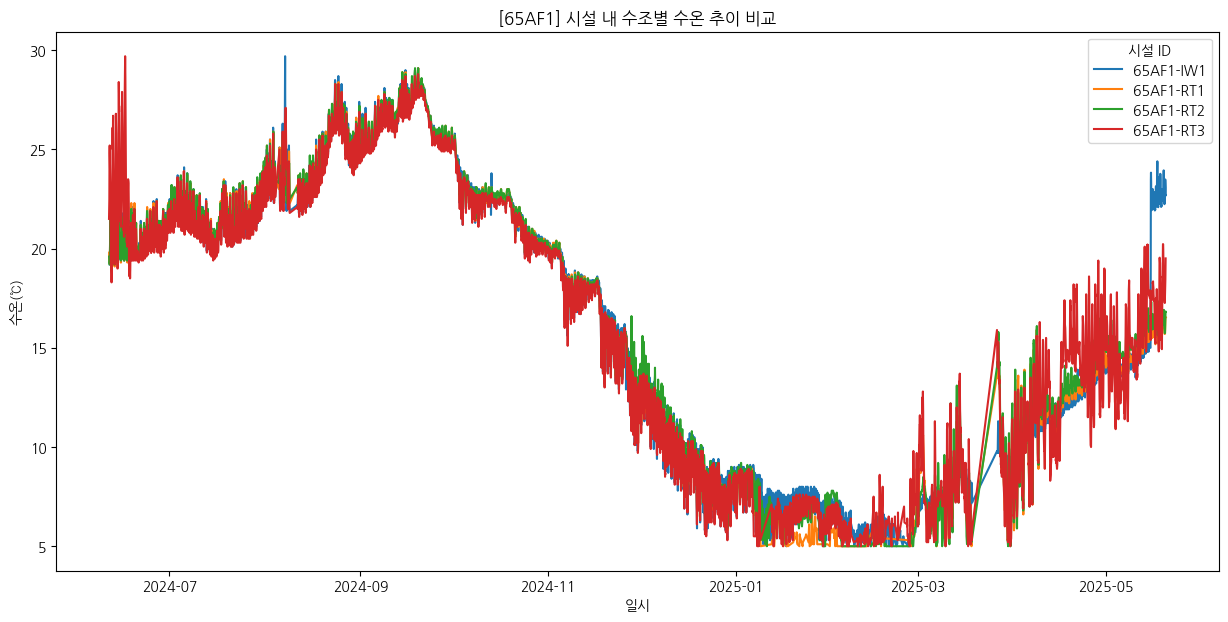

In [13]:
print("각 시설 내 수조별 데이터 추이를 시각적으로 비교합니다...")

for code in location_codes:
    # 현재 시설 코드에 해당하는 데이터만 선택합니다.
    location_df = temper_df[temper_df['시설 코드'] == code]
    
    # 해당 시설에 수조(센서)가 2개 이상 있을 경우에만 비교의 의미가 있습니다.
    if location_df['시설 ID'].nunique() < 2:
        continue
        
    plt.figure(figsize=(15, 7))
    
    # seaborn의 lineplot을 사용하여 '시설 ID'별로 색상을 다르게 하여 그립니다.
    sns.lineplot(data=location_df, x=location_df.index, y='수온(℃)', hue='시설 ID')
    
    plt.title(f'[{code}] 시설 내 수조별 수온 추이 비교')
    plt.xlabel('일시')
    plt.ylabel('수온(℃)')
    plt.legend(title='시설 ID')

    location_folder = os.path.join(main_figure_folder, code)
    os.makedirs(location_folder, exist_ok=True)
    filepath = os.path.join(location_folder, f"{code}_trend_comparison.png")
    plt.savefig(filepath)

    plt.show()

## 3단계: 수치적 유사도 분석 (상관계수 히트맵)

각 시설 내 수조별 데이터의 상관계수를 계산하여 유사도를 수치화합니다...


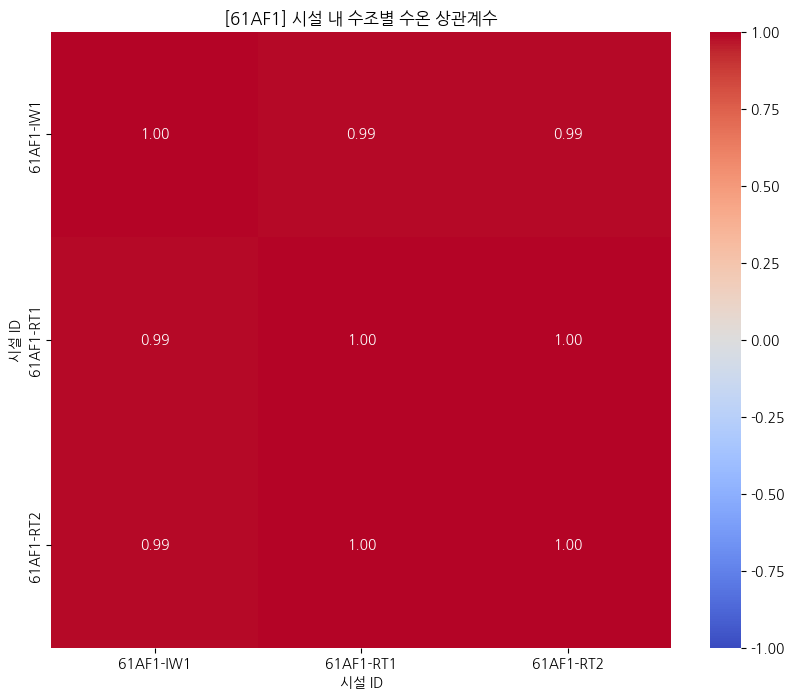

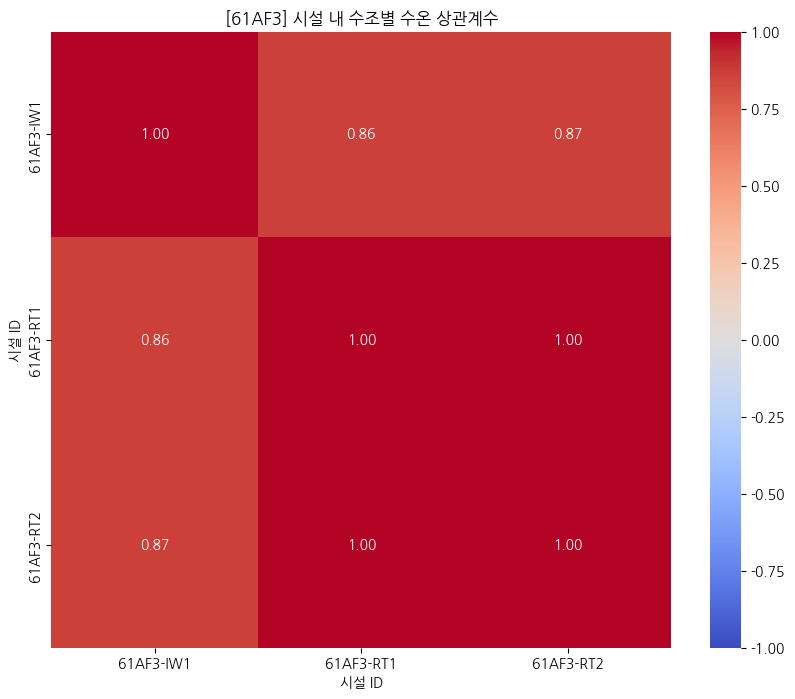

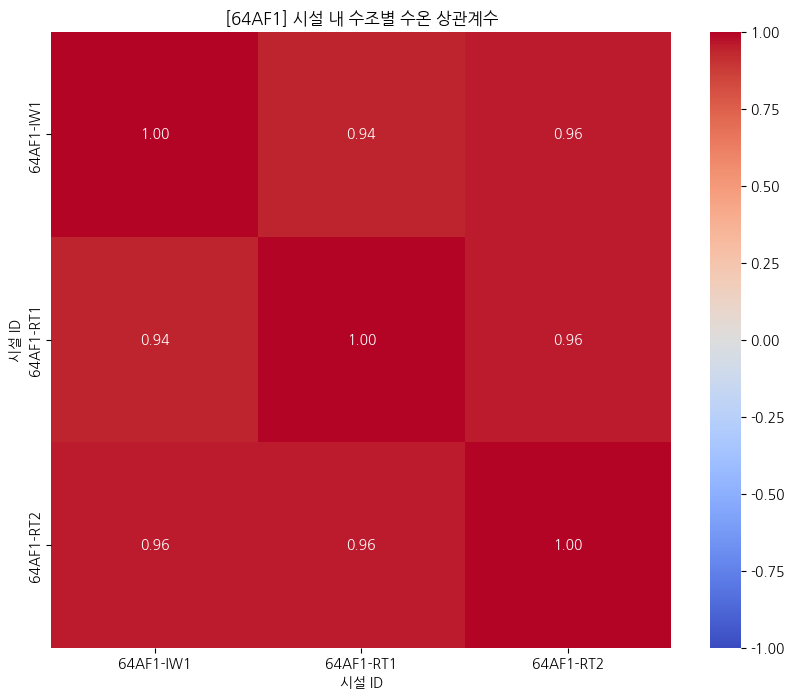

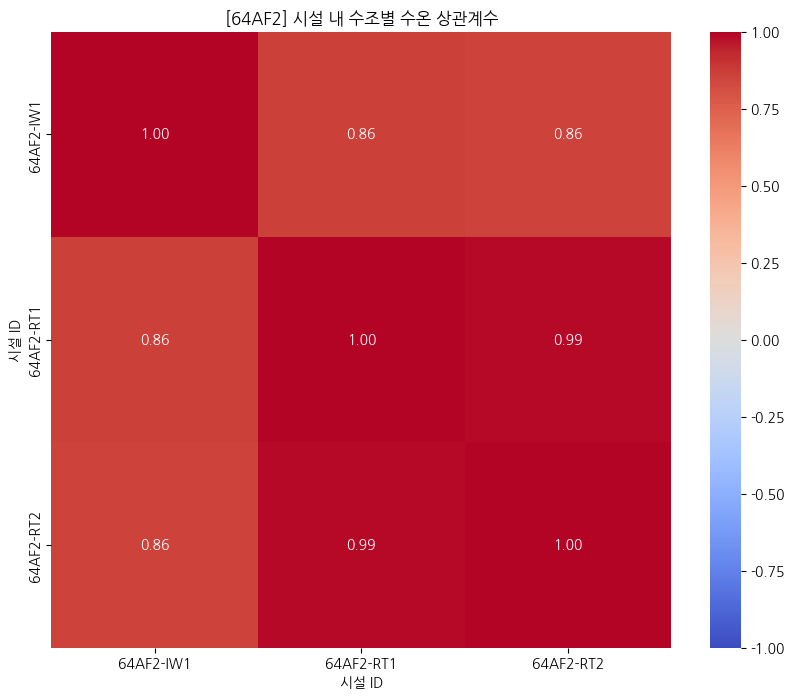

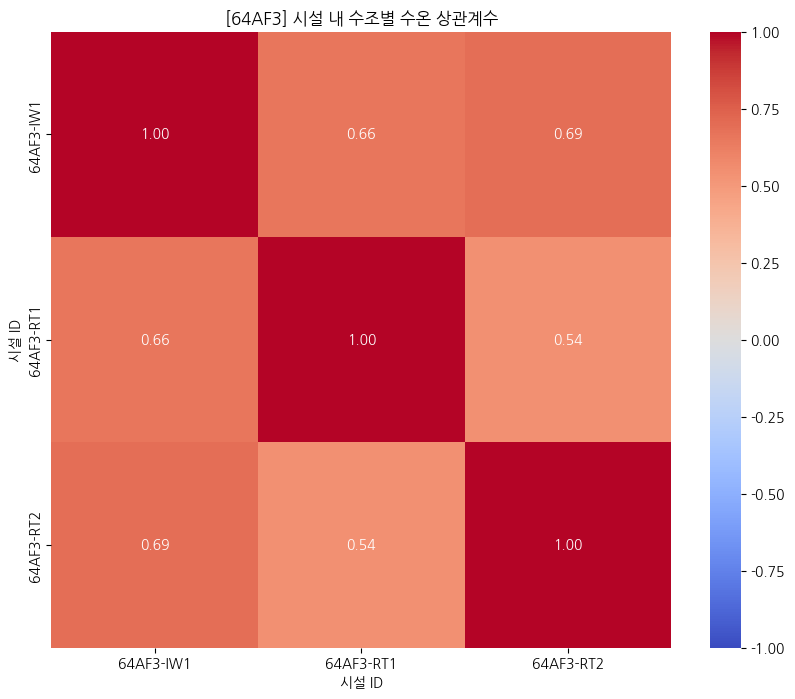

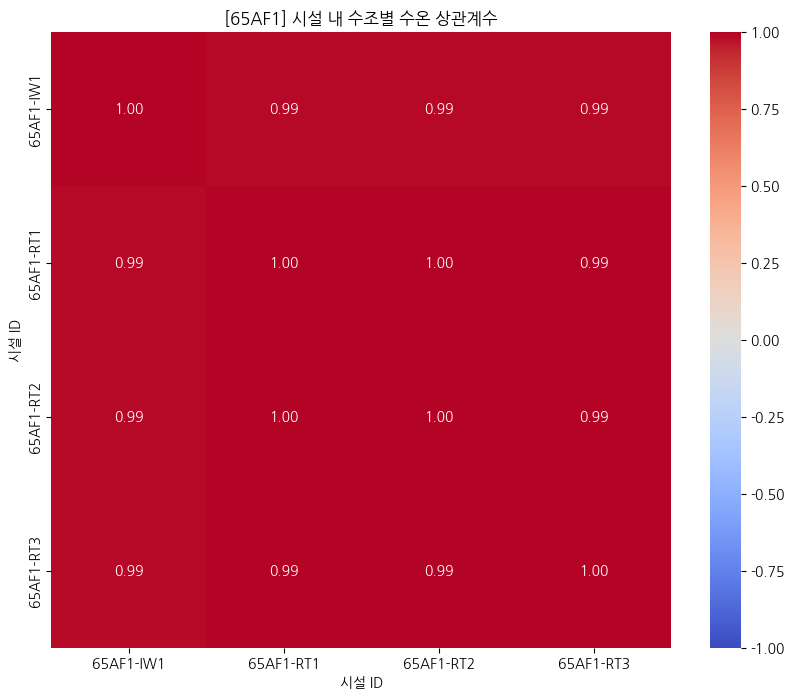

유사도 분석이 완료되었습니다.


In [14]:
print("각 시설 내 수조별 데이터의 상관계수를 계산하여 유사도를 수치화합니다...")

for code in location_codes:
    location_df = temper_df[temper_df['시설 코드'] == code]
    
    if location_df['시설 ID'].nunique() < 2:
        continue

    # [핵심] 데이터를 상관계산에 용이한 'wide' 형태로 변환합니다.
    # index는 '일시', columns는 '시설 ID', values는 '수온(℃)'이 됩니다.
    pivot_df = location_df.pivot_table(index='일시', columns='시설 ID', values='수온(℃)')
    
    # 리샘플링을 안했다면 시간 축이 안맞아 NaN이 많을 수 있습니다. 일별로 리샘플링합니다.
    pivot_df = pivot_df.resample('D').mean()
    
    # 상관계수를 계산합니다.
    correlation_matrix = pivot_df.corr()
    
    plt.figure(figsize=(10, 8))
    
    # 상관계수 행렬을 히트맵(heatmap)으로 시각화합니다.
    # annot=True: 각 셀에 숫자를 표시
    # cmap='coolwarm': 색상 테마 (1에 가까울수록 붉은색, -1에 가까울수록 푸른색)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    
    plt.title(f'[{code}] 시설 내 수조별 수온 상관계수')
    plt.savefig(f"{main_figure_folder}/{code}/{code}_correlation_heatmap.png")
    plt.show()

print("유사도 분석이 완료되었습니다.")

# 5단계: 데이터 유사도 분석에 근거하여 중점 데이터 획득

## 0단계: 필요한 라이브러리 및 데이터 준비

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

print("데이터가 준비되었다고 가정하고 분석을 시작합니다.")

데이터가 준비되었다고 가정하고 분석을 시작합니다.


## 1단계: 시설별 대표 데이터 생성

In [16]:
# 각 시설 코드의 대표 시계열 데이터를 저장할 딕셔너리를 생성합니다.
master_timeseries = {}

# 분석할 고유한 시설 코드 목록을 가져옵니다.
location_codes = temper_df['시설 코드'].unique()

print(f"총 {len(location_codes)}개의 시설에 대한 대표 데이터 생성을 시작합니다...")

for code in location_codes:
    # 현재 시설 코드에 해당하는 모든 데이터를 선택합니다.
    location_df = temper_df[temper_df['시설 코드'] == code]
    
    # ? 일별로 리샘플링 한 데이터를 단순 평균을 낸다면 유독 튀는 데이터가 다른 데이터를 변질 시키는거 아닌가?
    # [핵심] 일별(Daily)로 리샘플링하여 평균을 계산합니다.
    # 이 코드 한 줄이 마법의 핵심입니다. 
    # resample('D')는 데이터를 일별로 그룹핑하고, .mean()은 각 날짜에 포함된 
    # '모든 수조'의 측정값들의 평균을 계산합니다. 
    # 어떤 수조가 데이터를 보내지 않았더라도, 다른 수조가 보낸 데이터가 있다면 
    # 그 값들의 평균으로 그날의 대표 온도를 만들어냅니다.
    master_df = location_df[['수온(℃)']].resample('D').median()
    
    # [보완] 데이터를 전혀 수집하지 못한 날 때문에 생긴 빈 값(NaN)을
    # 앞뒤 날짜의 데이터 흐름에 맞게 부드럽게 채워줍니다. (보간)
    # master_df.interpolate(method='time', inplace=True)
    
    # 완성된 대표 데이터를 딕셔너리에 저장합니다.
    master_timeseries[code] = master_df

print("대표 데이터 생성 완료!")

총 6개의 시설에 대한 대표 데이터 생성을 시작합니다...
대표 데이터 생성 완료!


## 2단계: 생성된 '중점적인 그래프' 시각화

생성된 대표 그래프(마스터 시계열)를 확인합니다...


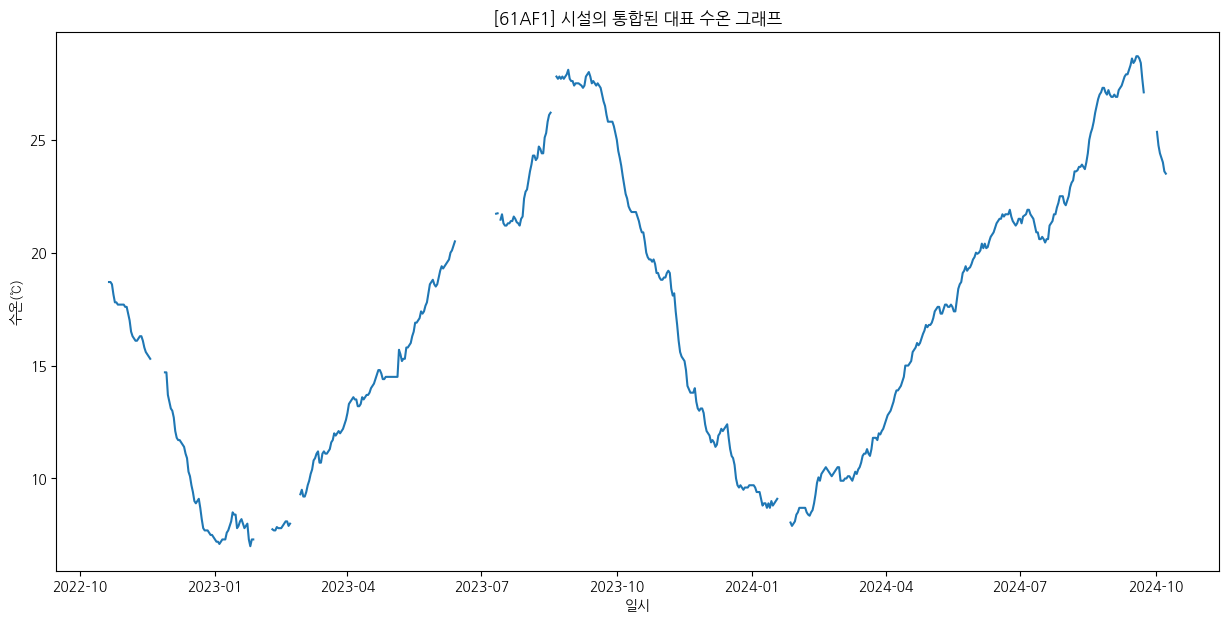

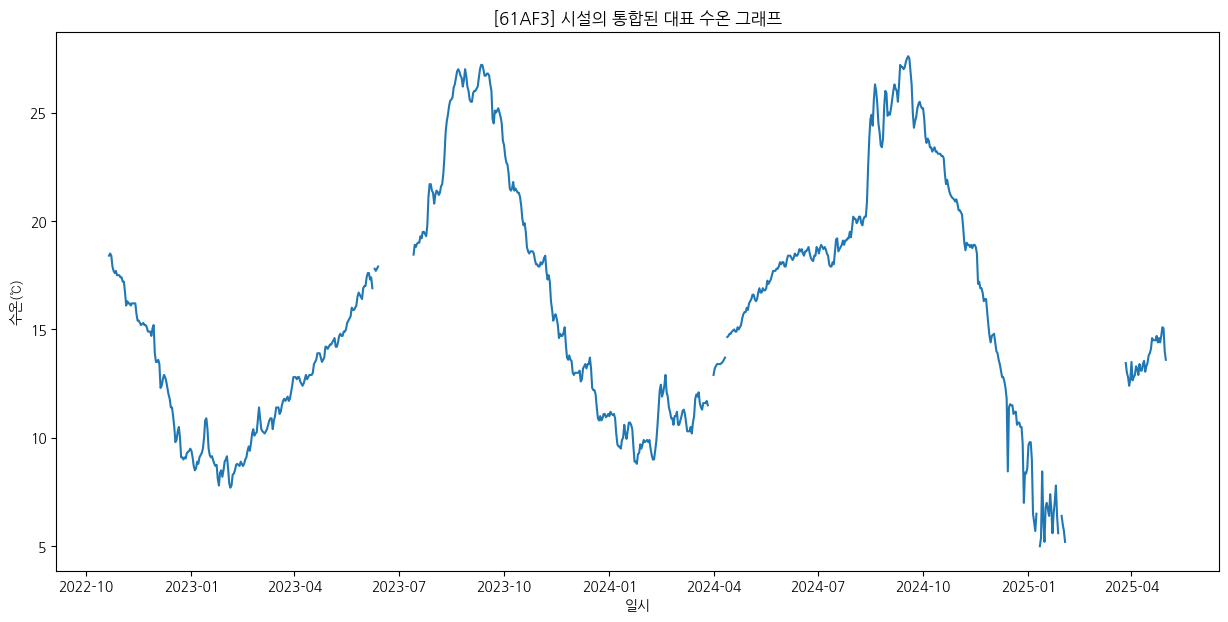

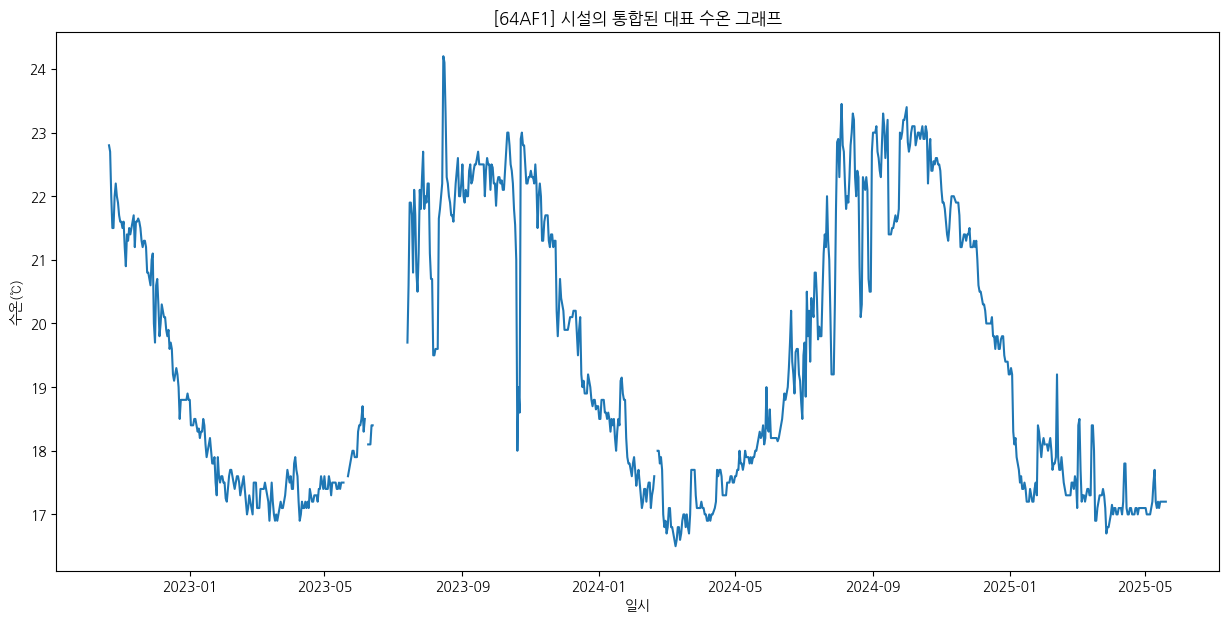

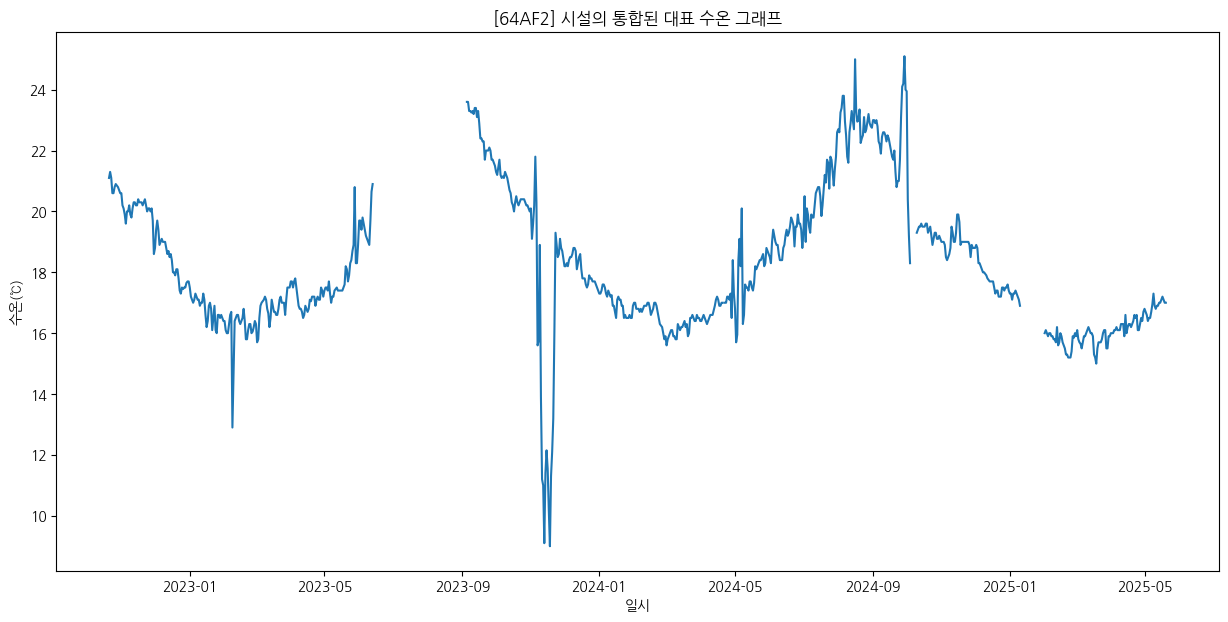

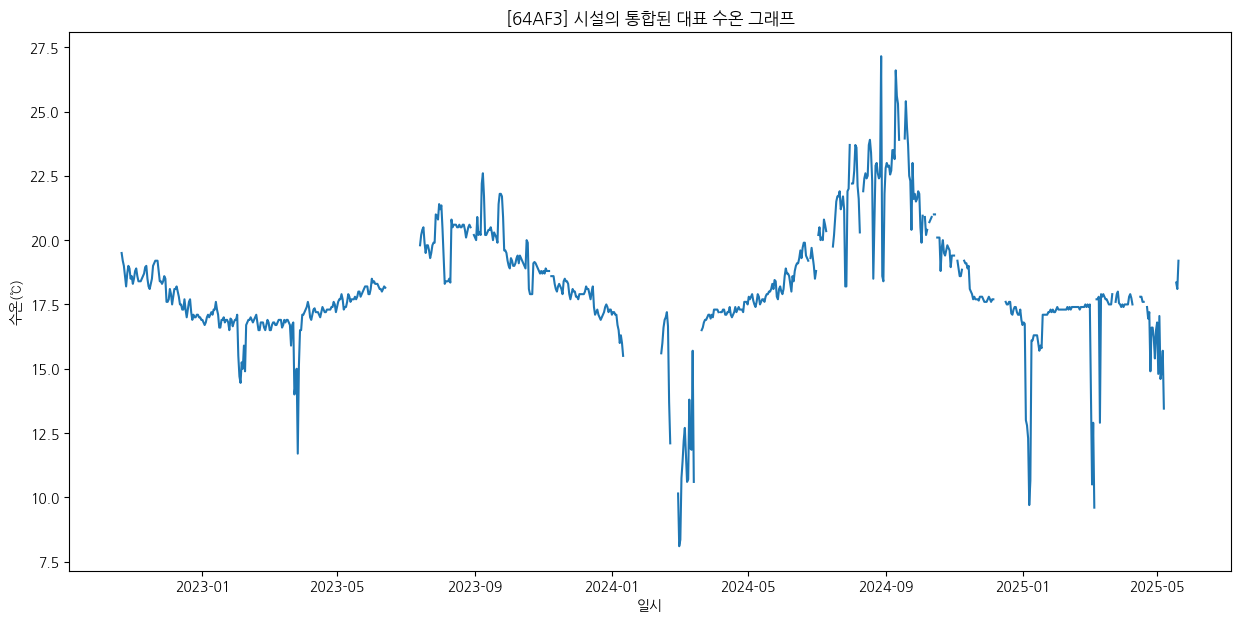

In [17]:
print("생성된 대표 그래프(마스터 시계열)를 확인합니다...")

# 딕셔너리에 저장된 데이터 중 처음 5개만 예시로 그려봅니다.
for i, code in enumerate(list(master_timeseries.keys())):
    if i >= 5:
        break
    
    plt.figure(figsize=(15, 7))
    
    # 딕셔너리에서 해당 시설의 대표 데이터를 가져와 그립니다.
    plt.plot(master_timeseries[code].index, master_timeseries[code]['수온(℃)'])
    
    plt.title(f"[{code}] 시설의 통합된 대표 수온 그래프")
    plt.xlabel('일시')
    plt.ylabel('수온(℃)')
    plt.savefig(f"{main_figure_folder}/{code}/{code}_master_timeseries.png")
    plt.show()

# 6단계: master_df를 이용하여 학습

17:21:19 - cmdstanpy - INFO - Chain [1] start processing


===== 61AF1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 719개
테스트 데이터 개수: 0개
-> [경고] 테스트 데이터가 없어 예측 성능 평가를 할 수 없으므로 건너뜁니다.

===== 61AF3 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 30개


17:21:19 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 2.36
-> 예측 구간 내 실제값 포함 비율 (Coverage): 0.00%


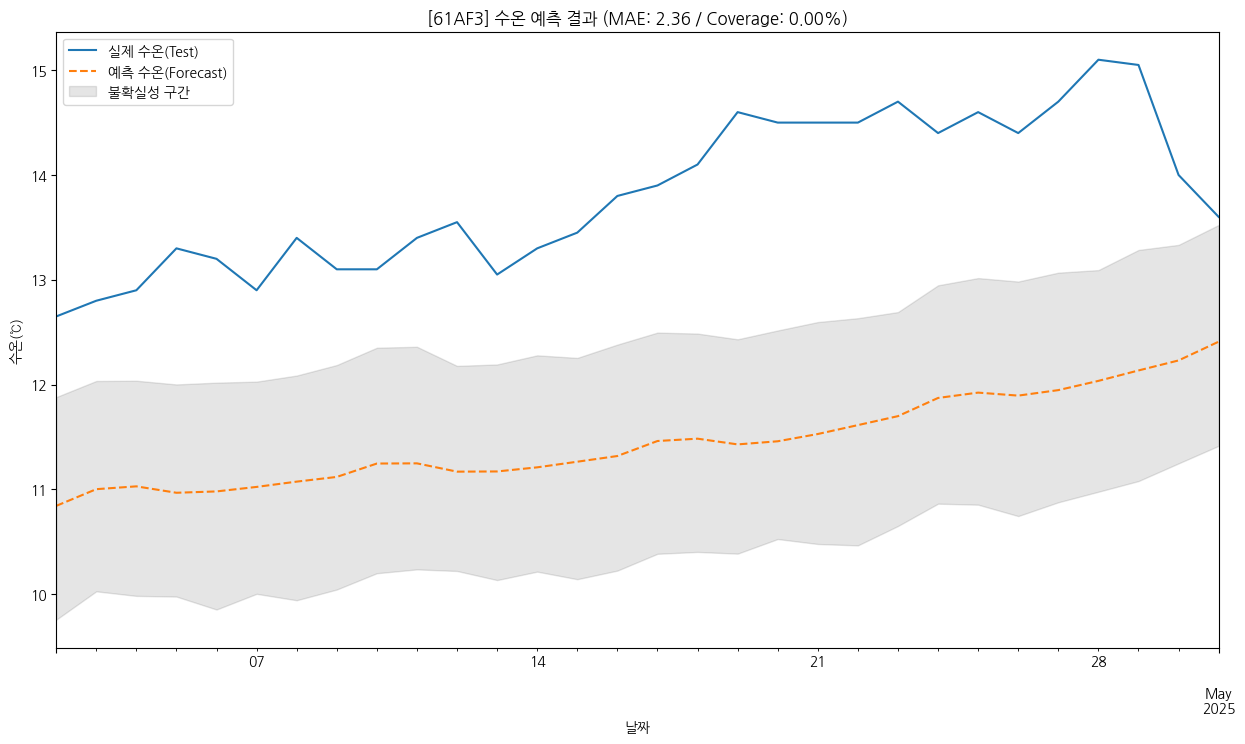

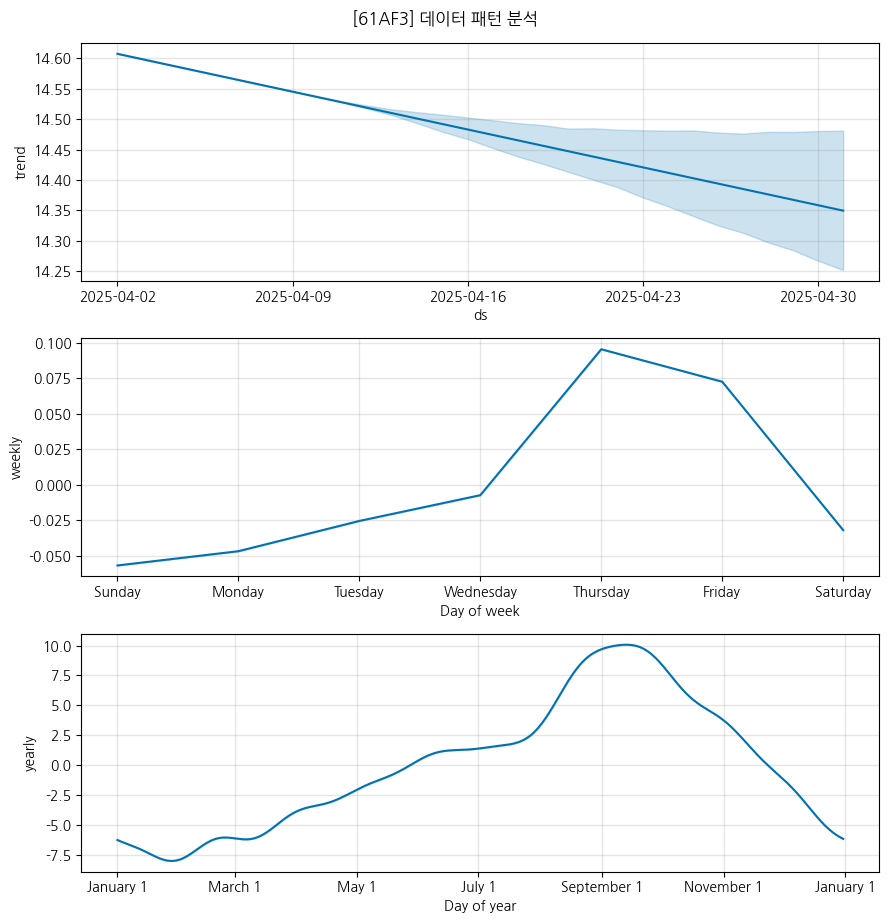

17:21:20 - cmdstanpy - INFO - Chain [1] start processing
17:21:20 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF1 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.49
-> 예측 구간 내 실제값 포함 비율 (Coverage): 79.59%


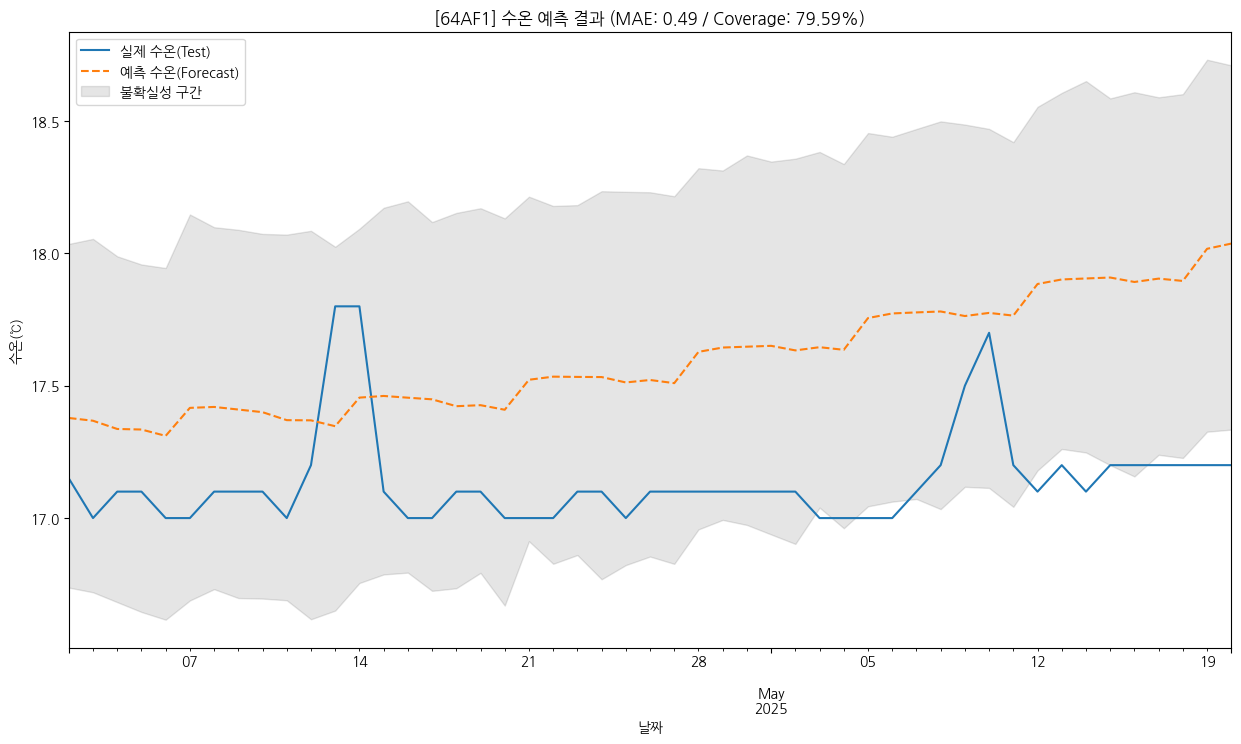

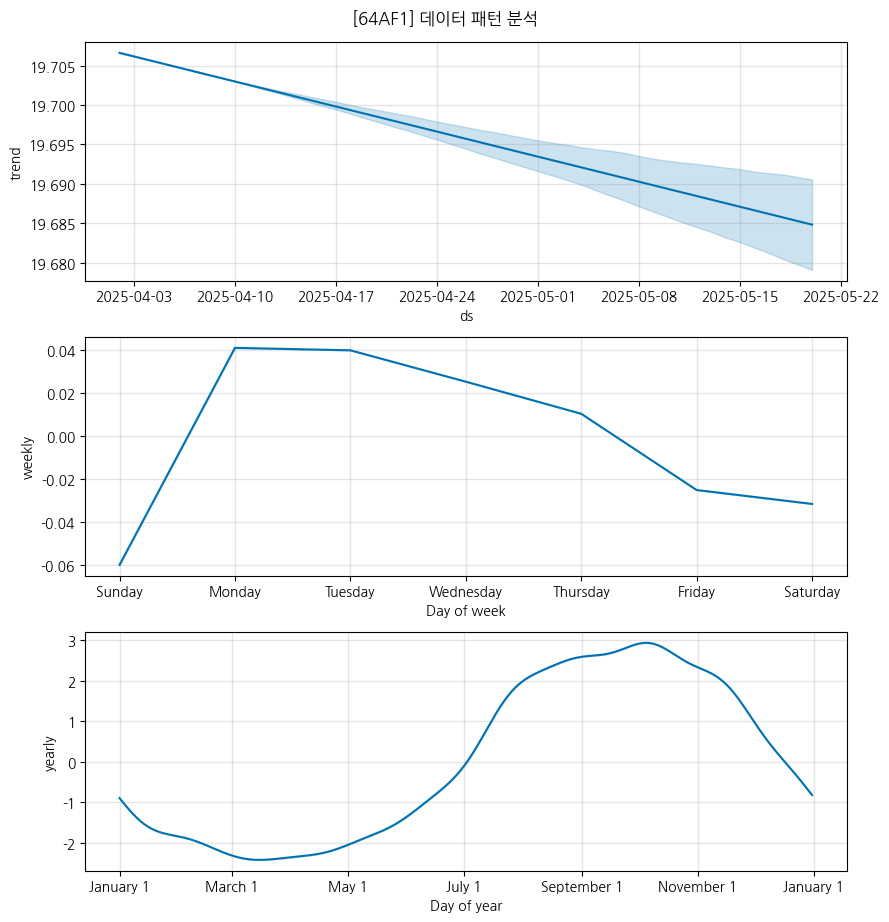

17:21:20 - cmdstanpy - INFO - Chain [1] start processing
17:21:20 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------
===== 64AF2 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개
-> 예측 평균 절대 오차(MAE): 0.38
-> 예측 구간 내 실제값 포함 비율 (Coverage): 100.00%


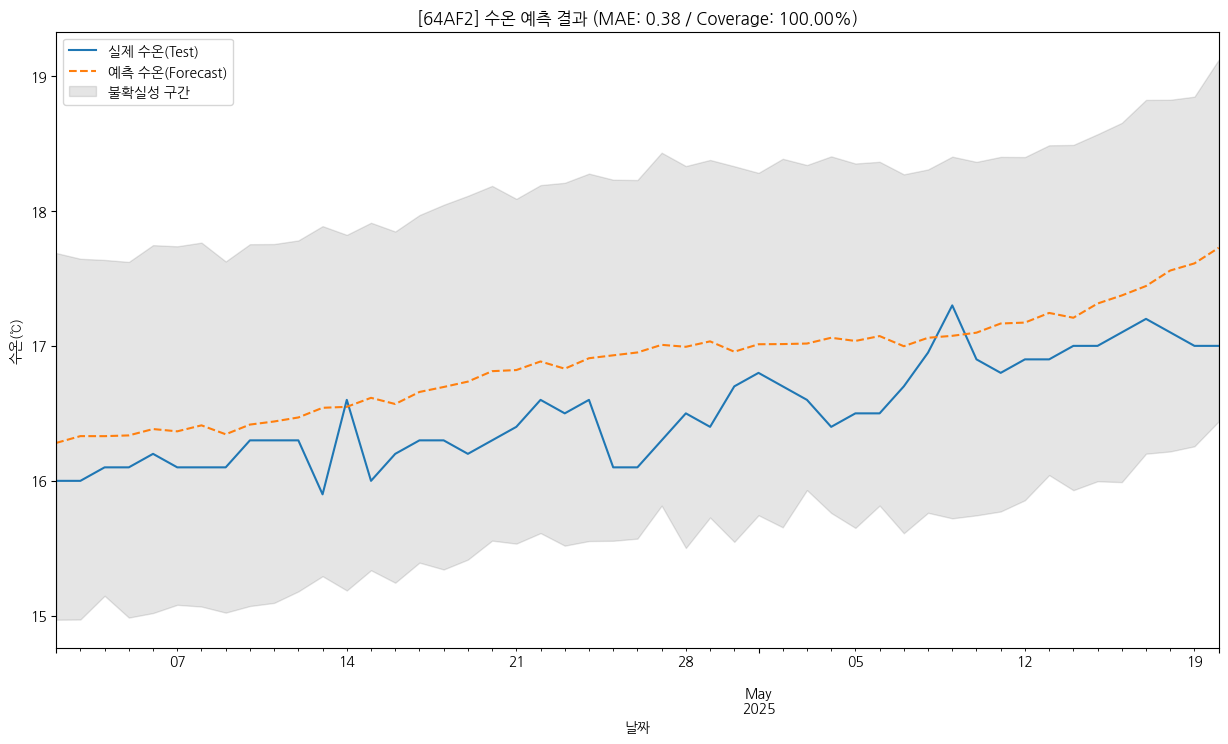

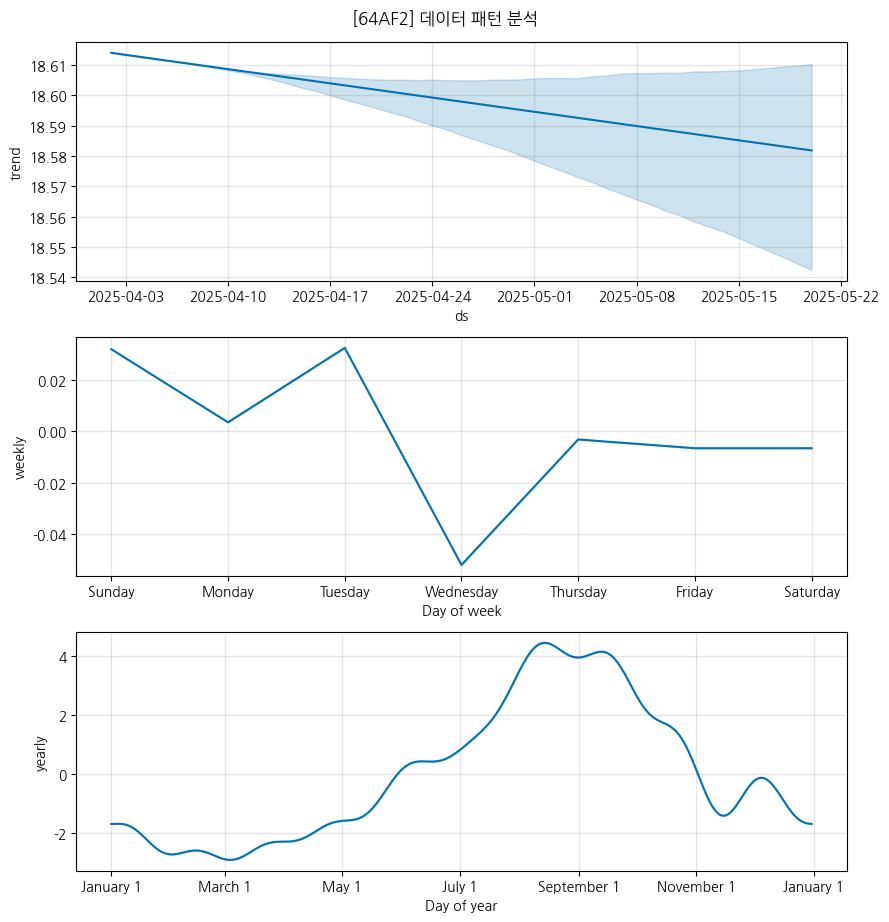

17:21:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------
===== 64AF3 시설에 대한 예측을 시작합니다. =====
학습 데이터 개수: 894개
테스트 데이터 개수: 49개


17:21:21 - cmdstanpy - INFO - Chain [1] done processing


-> 예측 평균 절대 오차(MAE): 1.41
-> 예측 구간 내 실제값 포함 비율 (Coverage): 64.52%


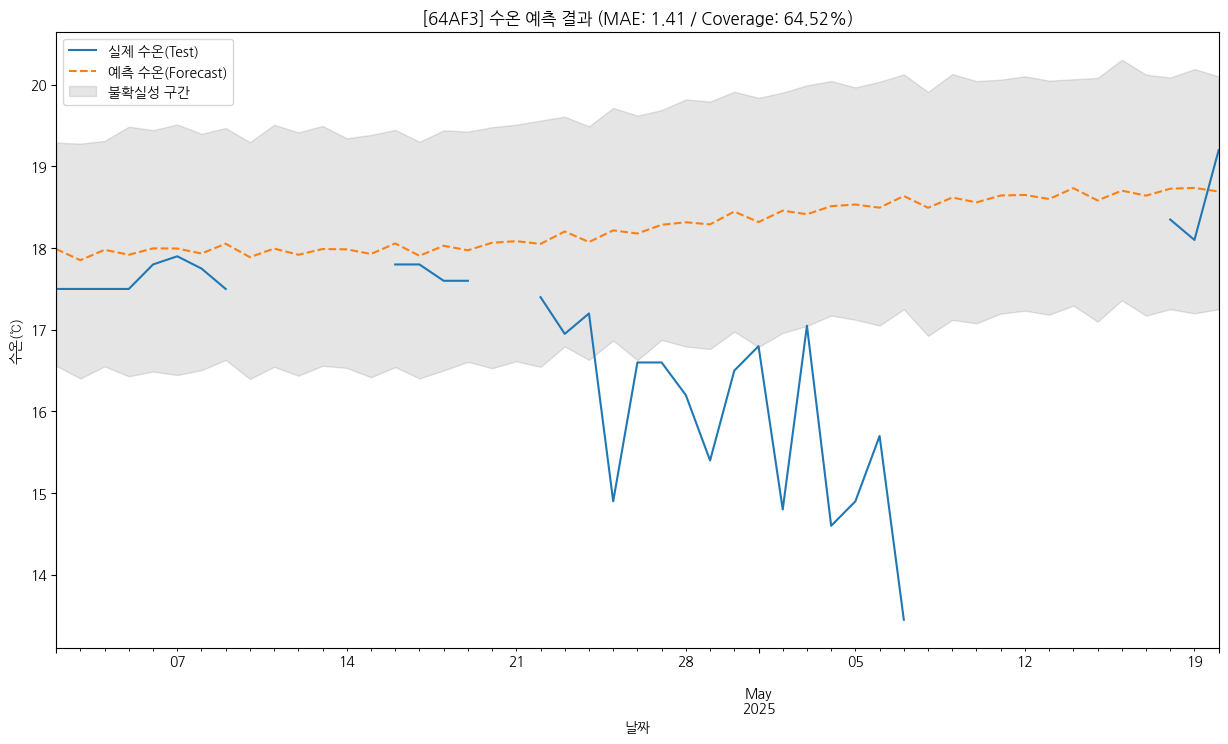

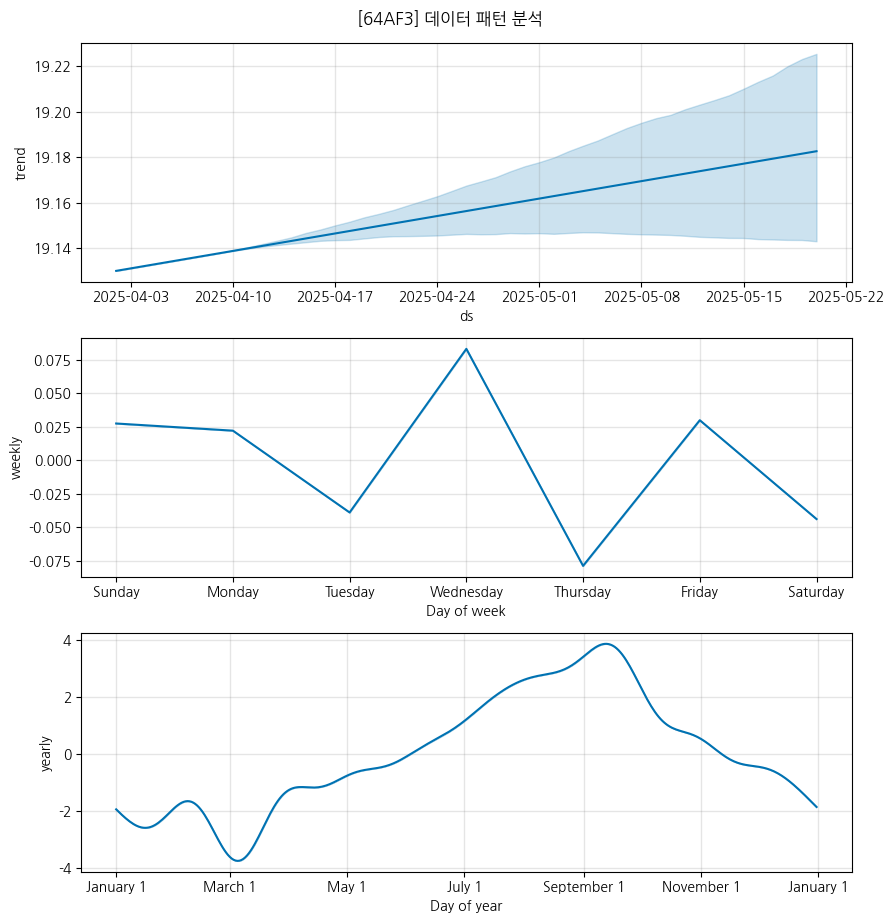

--------------------------------------------------
모든 시설에 대한 예측 및 분석이 완료되었습니다.


In [19]:
for i, code in enumerate(list(master_timeseries.keys())):
    if i >= 5:
        break
    
    print(f"===== {code} 시설에 대한 예측을 시작합니다. =====")

    # 3-1. 데이터 선택 및 정렬
    select_df = master_timeseries[code]
    select_df = select_df.sort_index()

    # --- [추천] 일별 데이터로 리샘플링 ---
    # 'D'는 Daily frequency(일별 주기)를 의미합니다.
    # .mean()을 사용해 해당 날짜의 모든 수온 값의 평균을 그날의 대표 값으로 사용합니다.
    # 하루에 데이터가 한 번도 없는 날은 비어있는 값(NaN)으로 표시됩니다.
    daily_df = select_df[['수온(℃)']].resample('D').mean() 

    # [선택 사항] 리샘플링 후 비어있는 날(NaN)을 채워줍니다.
    # 예를 들어, 특정 날에 데이터 수집이 전혀 안 된 경우, 앞뒤 날짜의 평균값 등으로 채웁니다.
    # interpolate는 데이터의 흐름에 맞게 부드럽게 채워주는 유용한 기능입니다.
    #daily_df.interpolate(method='time', inplace=True)

    # 3-2. 학습용 / 테스트용 데이터 분리
    prophet_train = daily_df.loc[daily_df.index <= split_date].copy()
    prophet_test = daily_df.loc[daily_df.index > split_date].copy()

    # 3-3. 학습 데이터 유효성 검사
    print(f"학습 데이터 개수: {len(prophet_train)}개")
    print(f"테스트 데이터 개수: {len(prophet_test)}개")
    
    # [방어 코드 1] 학습 데이터가 너무 적으면(2개 미만) 모델이 학습할 수 없습니다.
    if len(prophet_train) < 2:
        print(f"-> [경고] 학습 데이터가 부족하여 이 시설의 예측을 건너뜁니다.\n")
        continue  # 다음 시설로 넘어감

    # [방어 코드 2] 테스트 데이터가 없으면 예측 성능을 평가하고 비교할 수 없습니다.
    if len(prophet_test) == 0:
        print(f"-> [경고] 테스트 데이터가 없어 예측 성능 평가를 할 수 없으므로 건너뜁니다.\n")
        continue # 다음 시설로 넘어감

    # 3-4. Prophet을 위한 데이터 준비
    prophet_train.reset_index(inplace=True)
    prophet_train.rename(columns={'일시': 'ds', '수온(℃)': 'y'}, inplace=True)

    # 이상치(Outlier)를 제거
    outlier_count = prophet_train[(prophet_train['y'] > 35) | (prophet_train['y'] < 0)].shape[0]
    if outlier_count > 0:
        print(f"-> {outlier_count}개의 이상치를 감지하여 학습에서 제외합니다.")
        prophet_train.loc[(prophet_train['y'] > 35) | (prophet_train['y'] < 0), 'y'] = np.nan

    # 3-5. Prophet 모델 학습 및 예측
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_train)
    future = prophet_test.reset_index().rename(columns={'일시': 'ds'})[['ds']]
    try:
        forecast = model.predict(future)
    except Exception as e:
        print(prophet_train)
        print(f"-> 예측 중 오류 발생: {e}. 예측을 건너뜁니다.\n")
        continue

    # 3-6. 결과 분석 및 시각화
    comparison_df = prophet_test.copy()
    comparison_df['forecast'] = forecast['yhat'].values
    # Coverage 계산을 위해 lower/upper 바운드도 추가
    comparison_df['forecast_lower'] = forecast['yhat_lower'].values
    comparison_df['forecast_upper'] = forecast['yhat_upper'].values

    # 2. '수온(℃)' 또는 'forecast' 컬럼에 NaN이 있는 모든 행을 통째로 제거합니다.
    #    이렇게 하면 두 데이터의 길이가 정확히 맞춰집니다.
    comparison_df.dropna(subset=['수온(℃)'], inplace=True)

    # 3. 이제 NaN이 없는 깨끗한 데이터로 안전하게 MAE를 계산합니다.
    #    오류가 발생했던 아래 라드를 이렇게 수정합니다.
    if not comparison_df.empty:
        mae = mean_absolute_error(comparison_df['수온(℃)'], comparison_df['forecast'])
        print(f"-> 예측 평균 절대 오차(MAE): {mae:.2f}")
    else:
        mae = 'N/A' # 계산 불가
        print("-> MAE를 계산할 데이터가 없습니다.")
    
    if not comparison_df.empty:
        # 실제값이 예측 범위(lower ~ upper) 내에 있는지 확인 (True/False)
        comparison_df['in_bounds'] = (comparison_df['수온(℃)'] >= comparison_df['forecast_lower']) & \
                                        (comparison_df['수온(℃)'] <= comparison_df['forecast_upper'])
        
        # True의 비율을 계산하여 백분율로 변환
        coverage = comparison_df['in_bounds'].mean() * 100
        print(f"-> 예측 구간 내 실제값 포함 비율 (Coverage): {coverage:.2f}%")
    else:
        coverage = 'N/A'

    fig, ax = plt.subplots(figsize=(15, 8))
    prophet_test['수온(℃)'].plot(ax=ax, label='실제 수온(Test)', style='-')
    forecast.set_index('ds')['yhat'].plot(ax=ax, label='예측 수온(Forecast)', style='--')
    ax.fill_between(forecast['ds'].values, forecast['yhat_lower'].values, forecast['yhat_upper'].values, color='k', alpha=0.1, label='불확실성 구간')
    
    # 제목에 MAE와 Coverage를 함께 표시
    mae_str = f"{mae:.2f}" if isinstance(mae, float) else mae
    coverage_str = f"{coverage:.2f}%" if isinstance(coverage, float) else coverage
    ax.set_title(f'[{code}] 수온 예측 결과 (MAE: {mae_str} / Coverage: {coverage_str})')
    
    ax.set_xlabel('날짜')
    ax.set_ylabel('수온(℃)')
    plt.legend()
    
    # 파일 경로 생성 및 저장
    location_code_for_path = fi[:5]
    location_folder = os.path.join(main_figure_folder, location_code_for_path)
    os.makedirs(location_folder, exist_ok=True)
    filepath = os.path.join(location_folder, f"{code}_forecast.png")
    plt.savefig(filepath)
    plt.show()

    # 패턴 분석 그래프 저장
    model.plot_components(forecast)
    plt.suptitle(f'[{code}] 데이터 패턴 분석', y=1.02)
    filepath = os.path.join(location_folder, f"{code}_components.png")
    plt.savefig(filepath)
    plt.show()
    
    print("-" * 50)

print("모든 시설에 대한 예측 및 분석이 완료되었습니다.")